# HiPPO Matrices
---

## Table of Contents
* [Loading In Necessary Packages](#load-packages)
* [Instantiate The HiPPO Matrix](#instantiate-the-hippo-matrix)
    * [Translated Legendre (LegT)](#translated-legendre-legt)
        * [LegT](#legt)
        * [LMU](#lmu)
    * [Translated Laguerre (LagT)](#translated-laguerre-lagt)
    * [Scaled Legendre (LegS)](#scaled-legendre-legs)
    * [Fourier Basis](#fourier-basis)
        * [Fourier Recurrent Unit (FRU)](#fourier-recurrent-unit-fru)
        * [Truncated Fourier (FouT)](#truncated-fourier-fout)
        * [Fourier With Decay (FourD)](#fourier-with-decay-fourd)
* [Gu's Linear Time Invariant (LTI) HiPPO Operator](#gus-hippo-legt-operator)
* [Gu's Scale invariant (LSI) HiPPO Operator](#gus-scale-invariant-hippo-legs-operator)
* [Implementation Of General HiPPO Operator](#implementation-of-general-hippo-operator)
* [Test Generalized Bilinear Transform and Zero Order Hold Matrices](#test-generalized-bilinear-transform-and-zero-order-hold-matrices)
    * [Testing Forward Euler on GBT matrices](#testing-forward-euler-transform-for-lti-and-lsi)
    * [Testing Backward Euler on GBT matrices](#testing-backward-euler-transform-for-lti-and-lsi-on-legs-matrices)
    * [Testing Bidirectional on GBT matrices](#testing-lti-and-lsi-operators-with-bidirectional-transform)
    * [Testing ZOH on GBT matrices](#testing-zoh-transform-for-lti-and-lsi-on-legs-matrices)
* [Testing HiPPO Operators](#test-hippo-operators)
    * [Testing Forward Euler on HiPPO Operators](#testing-lti-and-lsi-operators-with-forward-euler-transform)
    * [Testing Backward Euler on HiPPO Operators](#testing-lti-and-lsi-operators-with-backward-euler-transform)
    * [Testing Bidirectional on HiPPO Operators](#testing-lti-and-lsi-operators-with-bidirectional-transform)
    * [Testing ZOH on HiPPO Operators](#testing-lti-and-lsi-operators-with-zoh-transform)
---


## Load Packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../../../"))
print(f"module_path: {module_path}")
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

module_path: /home/beegass/Documents/Coding/s4mer


In [2]:
## import packages
import math
from typing import Any, Callable, List, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import requests
from flax import linen as jnn
from jax.nn.initializers import lecun_normal, uniform
from jax.numpy.linalg import eig, inv, matrix_power
from jax.scipy.signal import convolve
from jaxtyping import Array, Float, Float16, Float32, Float64
from scipy import linalg as la
from scipy import signal
from scipy import special as ss

from src.data.process import moving_window, rolling_window
from src.models.hippo.gu_hippo import gu_HiPPO_LSI, gu_HiPPO_LTI

# import modules
from src.models.hippo.gu_transition import GuTransMatrix
from src.models.hippo.hippo import HiPPOLSI, HiPPOLTI
from src.models.hippo.transition import TransMatrix
from src.models.hippo.unroll import (
    basis,
    measure,
    variable_unroll_matrix,
    variable_unroll_matrix_sequential,
)
from src.utils.ops import genlaguerre, legendre_polynomial

print(jax.devices())
print(f"The Device: {jax.lib.xla_bridge.get_backend().platform}")

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
The Device: gpu


In [3]:
from functools import partial
from typing import Any

import einops
import functorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

print(f"MPS enabled: {torch.backends.mps.is_available()}")

MPS enabled: False


In [4]:
torch.set_printoptions(linewidth=150)
np.set_printoptions(linewidth=150)
jnp.set_printoptions(linewidth=150)

In [5]:
seed = 1701
key = jax.random.PRNGKey(seed)

In [6]:
num_copies = 10
subkeys = jax.random.split(key, num=num_copies)
key = subkeys[0]

In [7]:
def random_16_input(key_generator, batch_size=16, data_size=784, input_size=28):
    # x = jax.random.randint(key_generator, (batch_size, data_size), 0, 255)
    #x = jnp.linspace(-jnp.pi, jnp.pi, data_size)
    x = jax.random.uniform(key_generator, (batch_size, data_size))
    x = jax.vmap(moving_window, in_axes=(0, None))(x, input_size)
    print(f"x.shape: {x.shape}")
    x = jax.vmap(jnp.sin, in_axes=0)(x)
    print(f"x.shape: {x.shape}")
    return np.asarray(x)

## Test HiPPO Reconstruction

In [8]:
def test_hippo_reconstruction(
    hippo, gu_hippo, random_input, key, s_or_t="lti", print_all=False
):
    x_tensor = torch.tensor(random_input, dtype=torch.float32)
    x_jnp = jnp.asarray(x_tensor, dtype=jnp.float32)  # convert torch array to jax array

    # My Implementation
    if print_all:
        print(
            f"------------------------------------------------------------------------------------------"
        )
        print(
            f"----------------------------My {s_or_t} Implementation Outputs----------------------------"
        )
        print(
            f"------------------------------------------------------------------------------------------"
        )
    params = hippo.init(key, f=x_jnp)
    hippo = hippo.bind(params)
    c = hippo.__call__(f=x_jnp)
    y = hippo.reconstruct(c)

    mse = lambda y_hat, y: jnp.mean((y_hat - y) ** 2)
    batch_mse = jax.vmap(mse, in_axes=(0, 0))

    # Gu's HiPPO LegS
    if print_all:
        print(
            f"------------------------------------------------------------------------------------------"
        )
        print(
            f"---------------------------Gu's {s_or_t} Implementation Outputs---------------------------"
        )
        print(
            f"------------------------------------------------------------------------------------------"
        )
    x_tensor = torch.moveaxis(x_tensor, 0, 1)
    GU_c_s, GU_c_k = gu_hippo(x_tensor, fast=False)

    gu_y = None
    if s_or_t == "lsi":
        gu_y = gu_hippo.reconstruct(GU_c_s)
    elif s_or_t == "lti":
        gu_y = gu_hippo.reconstruct(GU_c_k)
    else:
        raise ValueError(
            f"s_or_t must be either 'lsi' or 'lti'. s_or_t is currently set to: {s_or_t}"
        )

    if s_or_t == "lsi":
        gu_c = jnp.asarray(
            GU_c_s, dtype=jnp.float32
        )  # convert torch array to jax array
        # (1, 64, 64, 1)
        y = einops.rearrange(
            y, "batch seq_len seq_len2 input_len -> batch seq_len input_len seq_len2"
        )
        gu_y = einops.rearrange(
            gu_y, "batch seq_len seq_len2 input_len -> batch seq_len input_len seq_len2"
        )
        
        spec_x = x_jnp[0]
        spec_x = einops.rearrange(spec_x, "seq_len 1 -> seq_len")
        print(f"spec_x.shape: {spec_x.shape}")
        
        spec_gu_y = gu_y[0][-1] + 0.05
        spec_gu_y = einops.rearrange(spec_gu_y, "1 seq_len -> seq_len")
        print(f"spec_gu_y.shape: {spec_gu_y.shape}")
        
        spec_y = y[0][-1]
        spec_y = einops.rearrange(spec_y, "1 seq_len -> seq_len")
        print(f"spec_y.shape: {spec_y.shape}")
        
        vals = np.arange(0.0, x_jnp.shape[1], 1)
        plt.figure(figsize=(16, 8))
        plt.plot(vals, spec_x, color='k', linewidth=2.0)
        plt.plot(spec_gu_y, color='r', linewidth=1.0)
        plt.plot(spec_y, color='b', linewidth=1.0)
        plt.plot(vals[-len(spec_y):], spec_y)
        plt.plot(vals[-len(spec_gu_y):], spec_gu_y)
        plt.show()

    elif s_or_t == "lti":
        gu_c = jnp.asarray(
            GU_c_k, dtype=jnp.float32
        )  # convert torch array to jax array
        # (1, 64, 1)
        y = einops.rearrange(y, "batch seq_len input_len -> batch input_len seq_len")
        gu_y = einops.rearrange(
            gu_y, "batch seq_len input_len -> batch input_len seq_len"
        )
        
        spec_x = x_jnp[0]
        spec_x = einops.rearrange(spec_x, "seq_len 1 -> seq_len")
        print(f"spec_x.shape: {spec_x.shape}")
        
        spec_gu_y = gu_y[0] + 0.05
        spec_gu_y = einops.rearrange(spec_gu_y, "1 seq_len -> seq_len")
        print(f"spec_gu_y.shape: {spec_gu_y.shape}")
        
        spec_y = y[0] 
        spec_y = einops.rearrange(spec_y, "1 seq_len -> seq_len")
        print(f"spec_y.shape: {spec_y.shape}")
        
        vals = np.arange(0.0, x_jnp.shape[1], 1)
        plt.figure(figsize=(16, 8))
        plt.plot(vals, spec_x, color='k', linewidth=2.0)
        plt.plot(spec_gu_y, color='r', linewidth=1.0)
        plt.plot(spec_y, color='b', linewidth=1.0)
        plt.plot(vals[-len(spec_y):], spec_y)
        plt.plot(vals[-len(spec_gu_y):], spec_gu_y)
        plt.show()

    gu_y = jnp.asarray(gu_y, dtype=jnp.float32)  # convert torch array to jax array

    x_tensor = jnp.asarray(
        x_tensor, dtype=jnp.float32
    )  # convert torch array to jax array
    x_tensor = jnp.moveaxis(x_tensor, 0, 1)

    co_flag = True
    y_flag = True
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):

            co_check = None
            y_check = None
            if s_or_t == "lsi":
                co_check = jnp.allclose(
                    c[i, j, :, :], gu_c[i, j, :, :], rtol=1e-03, atol=1e-03
                )
                y_check = jnp.allclose(
                    y[i, j, :, :], gu_y[i, j, :, :], rtol=1e-03, atol=1e-03
                )

                if print_all:
                    print(f"c_k[{i},{j},:,:]:\n{c[i,j,:,:]}")
                    print(f"gu_cs[{i},{j},:,:]:\n{gu_c[i,j,:,:]}")
                    print(f"coefficients check: {co_check}\n")

                    print(f"y[{i},{j},:,:]:\n{y[i,j,:,:]}")
                    print(f"gu_y[{i},{j},:,:]:\n{gu_y[i,j,:,:]}")
                    print(f"reconstruction check: {y_check}\n")

            elif s_or_t == "lti":
                co_check = jnp.allclose(
                    c[i, j, :], gu_c[i, :, :], rtol=1e-03, atol=1e-03
                )
                y_check = jnp.allclose(
                    y[i, j, :], gu_y[i, :, :], rtol=1e-03, atol=1e-03
                )

                if print_all:
                    print(f"c_k[{i},{j},:]:\n{c[i,:,:]}")
                    print(f"gu_cs[{i},{j},:]:\n{gu_c[i,j,:]}")
                    print(f"coefficients check: {co_check}\n")

                    print(f"y[{i},{j},:]:\n{y[i,:,:]}")
                    print(f"gu_y[{i},{j},:]:\n{gu_y[i,:,:]}")
                    print(f"reconstruction check: {y_check}\n")

            if co_check == False:
                co_flag = False

            if y_check == False:
                y_flag = False

    if not print_all:
        print(f"\n------------------------------------------------------------")
        print(f"---------- The Coefficients Test Passed: {co_flag} ----------")
        print(f"-------------------------------------------------------------\n\n")
        print(f"\n-------------------------------------------------------------")
        print(f"---------- The Reconstruction Test Passed: {y_flag} ----------")
        print(f"--------------------------------------------------------------\n")

    if print_all:
        print(f"c:\n {c}")
        print(f"c shape:\n {c.shape}")

        print(f"gu_c:\n {gu_c}")
        print(f"gu_c shape:\n {gu_c.shape}")

        print(f"y:\n {y}")
        print(f"y shape:\n {y.shape}")

        print(f"gu_y:\n {gu_y}")
        print(f"gu_y shape:\n {gu_y.shape}")
        

    # time_allclose = jax.vmap(jnp.allclose, in_axes=(0, 0, None, None))
    # batch_time_allclose = jax.vmap(time_allclose, in_axes=(0, 0, None, None))
    # print(f"Test y:\n{batch_time_allclose(y, gu_y, 1e-04, 1e-04)}\n")
    # print(f"y Loss:\n {batch_mse(gu_y, x_tensor)}\n")
    # print(f"gu's y Loss:\n {batch_mse(y, x_jnp)}\n\n\n")

In [9]:
def test_reconstruction(
    the_measure="legs", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=False
):
    # N = 256
    # L = 128

    batch_size = 2
    data_size = 100
    input_size = 1

    N = 50
    L = data_size
    
    step = 1.0

    x_jnp = random_16_input(
        key_generator=subkeys[4],
        batch_size=batch_size,
        data_size=data_size,
        input_size=input_size,
    )
    x_np = np.asarray(x_jnp)

    x = torch.tensor(x_np, dtype=torch.float32)

    # ----------------------------------------------------------------------------------
    # ------------------------------ Instantiate Gu's HiPPOs ---------------------------
    # ----------------------------------------------------------------------------------

    print(f"Creating Gu's HiPPO-{the_measure} LTI model with {alpha} transform")
    gu_hippo_lti = gu_HiPPO_LTI(
        N=N,
        method=the_measure,
        dt=step,
        T=L,
        discretization=discretization,
        lambda_n=lambda_n,
        alpha=0.0,
        beta=1.0,
        c=0.0,
    )  # The Gu's

    if the_measure == "legs":
        print(f"Creating Gu's HiPPO-{the_measure} LSI model with {alpha} transform")
        gu_hippo_lsi = gu_HiPPO_LSI(
            N=N,
            method=the_measure,
            max_length=L,
            discretization=discretization,
            lambda_n=lambda_n,
            alpha=0.0,
            beta=1.0,
        )  # The Gu's

    # ----------------------------------------------------------------------------------
    # ------------------------------ Instantiate My HiPPOs -----------------------------
    # ----------------------------------------------------------------------------------
    print(f"\nTesting BRYANS HiPPO-{the_measure} model")

    matrices = TransMatrix(
        N=N,
        measure=the_measure,
        lambda_n=lambda_n,
        alpha=0.0,
        beta=1.0,
        dtype=jnp.float32,
    )

    A = matrices.A
    B = matrices.B

    print(f"Creating HiPPO-{the_measure} LTI model with {alpha} transform")
    hippo_lti = HiPPOLTI(
        N=N,
        step_size=step,
        lambda_n=lambda_n,
        alpha=0.0,
        beta=1.0,
        GBT_alpha=alpha,
        measure=the_measure,
        basis_size=L,
        dtype=jnp.float32,
        unroll=False,
    )  # Bryan's

    if the_measure == "legs":
        print(f"Creating HiPPO-{the_measure} LSI model with {alpha} transform")
        hippo_lsi = HiPPOLSI(
            N=N,
            max_length=L,
            step_size=step,
            lambda_n=lambda_n,
            alpha=0.0,
            beta=1.0,
            GBT_alpha=alpha,
            measure=the_measure,
            dtype=jnp.float32,
            unroll=True,
        )  # Bryan's

    # ----------------------------------------------------------------------------------
    # ------------------------------ Test HiPPO Operators ------------------------------
    # ----------------------------------------------------------------------------------

    print(f"Bryan's Coeffiecients for {alpha} LTI HiPPO-{the_measure}")

    test_hippo_reconstruction(
        hippo=hippo_lti,
        gu_hippo=gu_hippo_lti,
        random_input=x_np,
        key=subkeys[5],
        s_or_t="lti",
        print_all=print_all,
    )

    if the_measure == "legs":
        print(f"\n\nBryan's Coeffiecients for {alpha} LSI HiPPO-{the_measure}")

        test_hippo_reconstruction(
            hippo=hippo_lsi,
            gu_hippo=gu_hippo_lsi,
            random_input=x_np,
            key=subkeys[6],
            s_or_t="lsi",
            print_all=print_all,
        )

    print(f"end of test for HiPPO-{the_measure} model")

## Navigation To Table Of Contents
---
* [Table Of Contents](#table-of-contents)
* [Loading In Necessary Packages](#load-packages)
* [Instantiate The HiPPO Matrix](#instantiate-the-hippo-matrix)
* [Gu's Linear Time Invariant (LTI) HiPPO Operator](#gus-hippo-legt-operator)
* [Gu's Scale invariant (LSI) HiPPO Operator](#gus-scale-invariant-hippo-legs-operator)
* [Implementation Of General HiPPO Operator](#implementation-of-general-hippo-operator)
* [Test Generalized Bilinear Transform and Zero Order Hold Matrices](#test-generalized-bilinear-transform-and-zero-order-hold-matrices)
* [Testing HiPPO Operators](#test-hippo-operators)
---

In [10]:
print_all = True

### Testing (LTI and LSI) Operators With Forward Euler Transform

#### LegS

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legs LTI model with 0.0 transform
Creating Gu's HiPPO-legs LSI model with 0.0 transform

Testing BRYANS HiPPO-legs model
Creating HiPPO-legs LTI model with 0.0 transform
Creating HiPPO-legs LSI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-legs
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


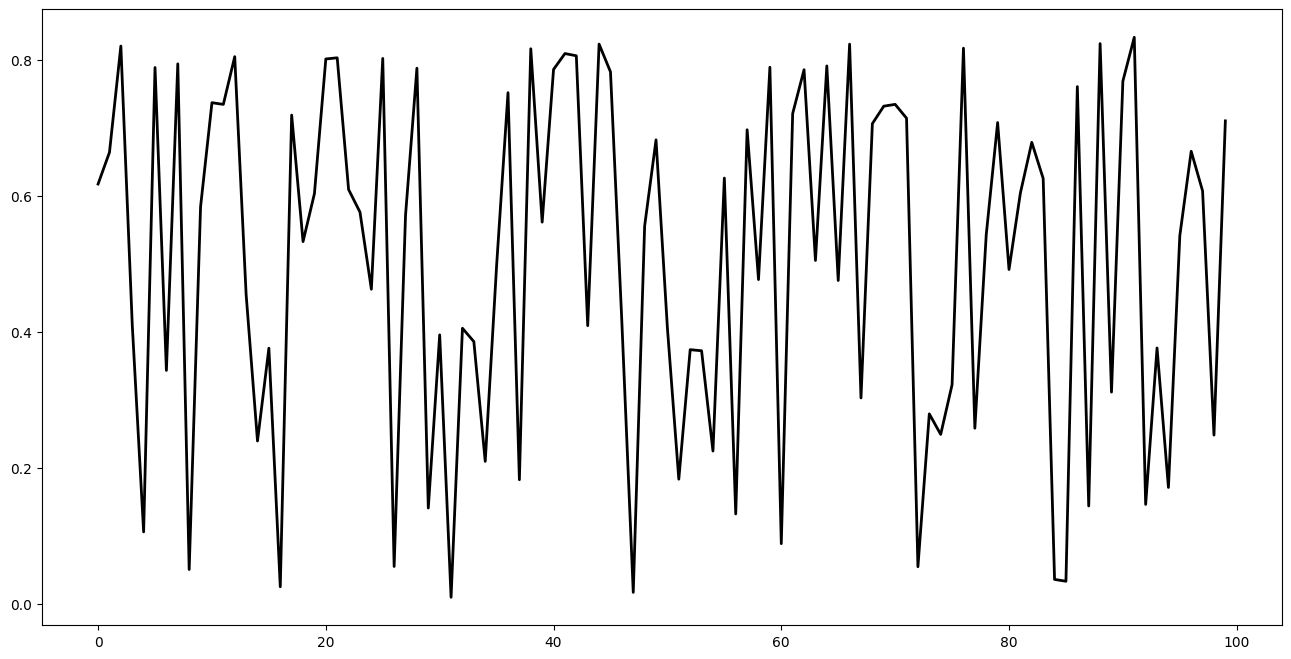

c_k[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_cs[0,0,:]:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
coefficients check: False

y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

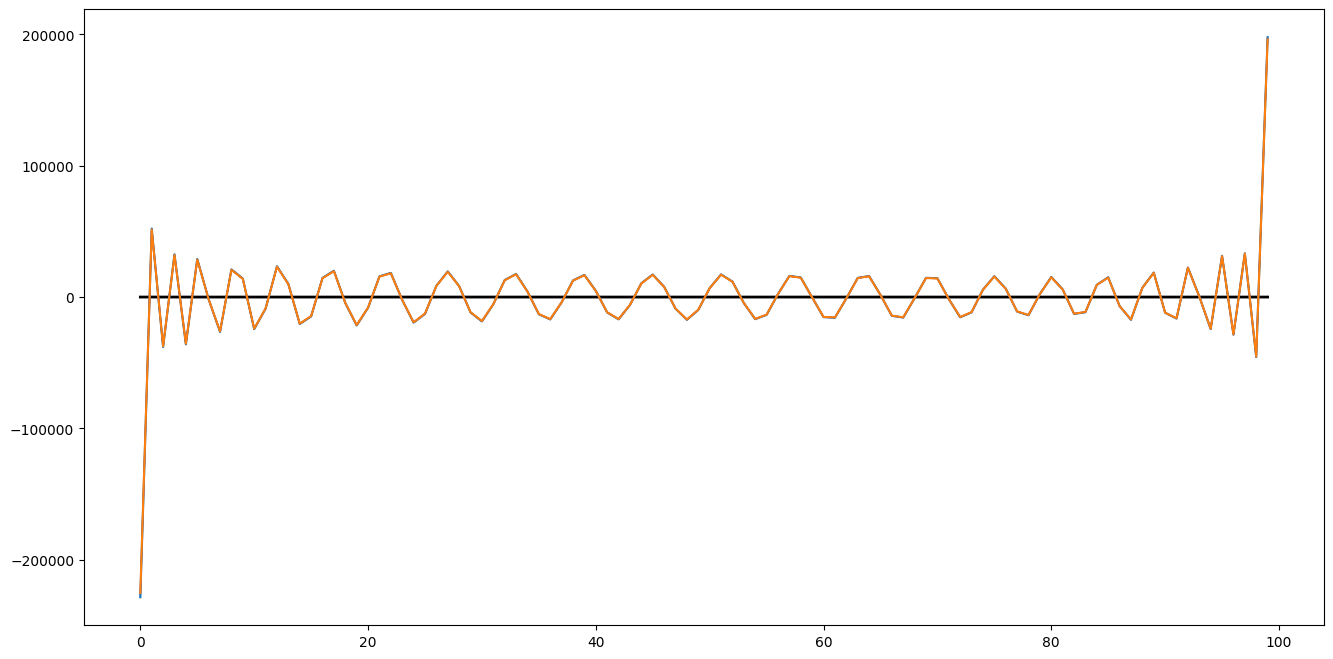

c_k[0,0,:,:]:
[[0.6179574 1.0703336 1.3817947 1.6349616 1.8538723 2.049533  2.2280772 2.3933387 2.5479035 2.6936138 2.8318365 2.9636195 3.089787  3.2110007
  3.3278024 3.4406412 3.549895  3.6558852 3.758888  3.8591428 3.956858  4.0522175 4.1453843 4.236502  4.3257017 4.413099  4.498798  4.582895
  4.665476  4.746621  4.826401  4.904885  4.982132  5.058199  5.1331396 5.2070017 5.2798305 5.351668  5.4225545 5.4925256 5.561617  5.62986
  5.6972857 5.7639227 5.829798  5.8949375 5.959365  6.023103  6.086175  6.148598 ]]
gu_cs[0,0,:,:]:
[[0.6179574 1.0703336 1.3817947 1.6349616 1.8538723 2.049533  2.2280772 2.3933387 2.5479035 2.6936138 2.8318365 2.9636195 3.089787  3.2110007
  3.3278024 3.4406412 3.549895  3.6558852 3.758888  3.8591428 3.956858  4.0522175 4.1453843 4.236502  4.3257017 4.413099  4.498798  4.582895
  4.665476  4.746621  4.826401  4.904885  4.982132  5.058199  5.1331396 5.2070017 5.2798305 5.351668  5.4225545 5.4925256 5.561617  5.62986
  5.6972857 5.7639227 5.829798  5.894937

In [11]:
test_reconstruction(
    the_measure="legs", lambda_n=1.0, alpha=0.0, discretization=0.0, print_all=print_all
)

#### LegT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legt LTI model with 0.0 transform

Testing BRYANS HiPPO-legt model
Creating HiPPO-legt LTI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-legt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------


/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4983: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


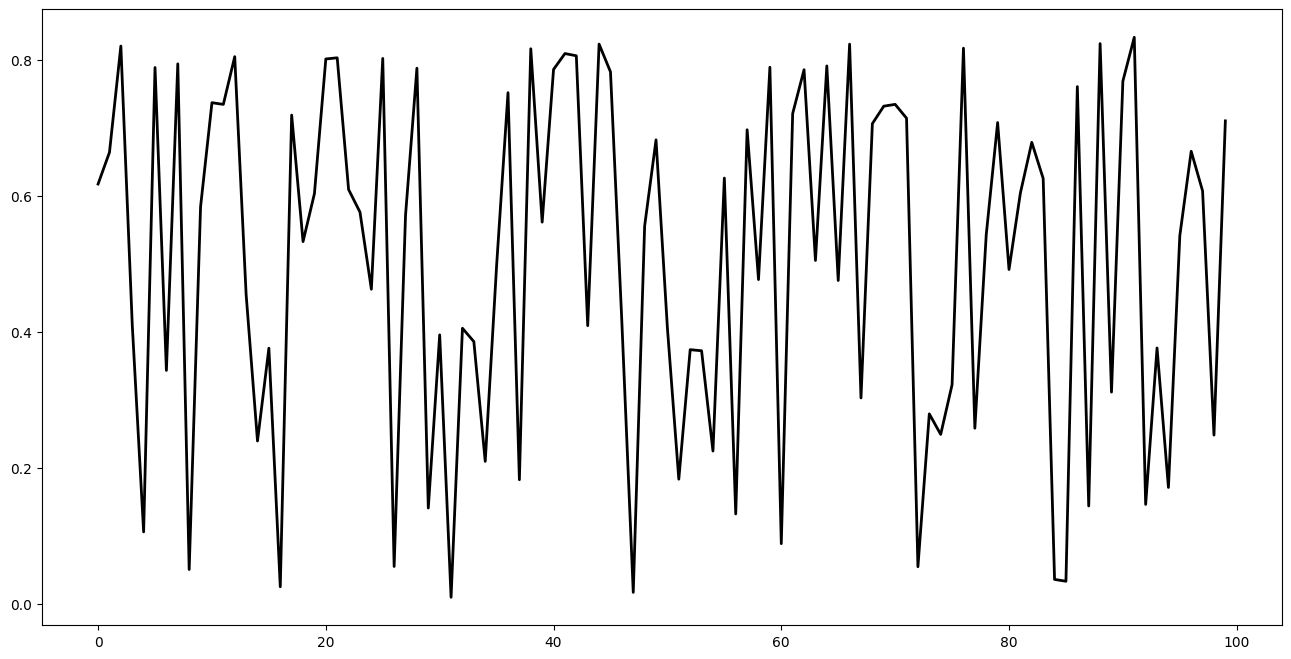

c_k[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_cs[0,0,:]:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
coefficients check: False

y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

In [12]:
test_reconstruction(
    the_measure="legt", lambda_n=1.0, alpha=0.0, discretization=0.0, print_all=print_all
)

#### LMU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lmu LTI model with 0.0 transform

Testing BRYANS HiPPO-lmu model
Creating HiPPO-lmu LTI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-lmu
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


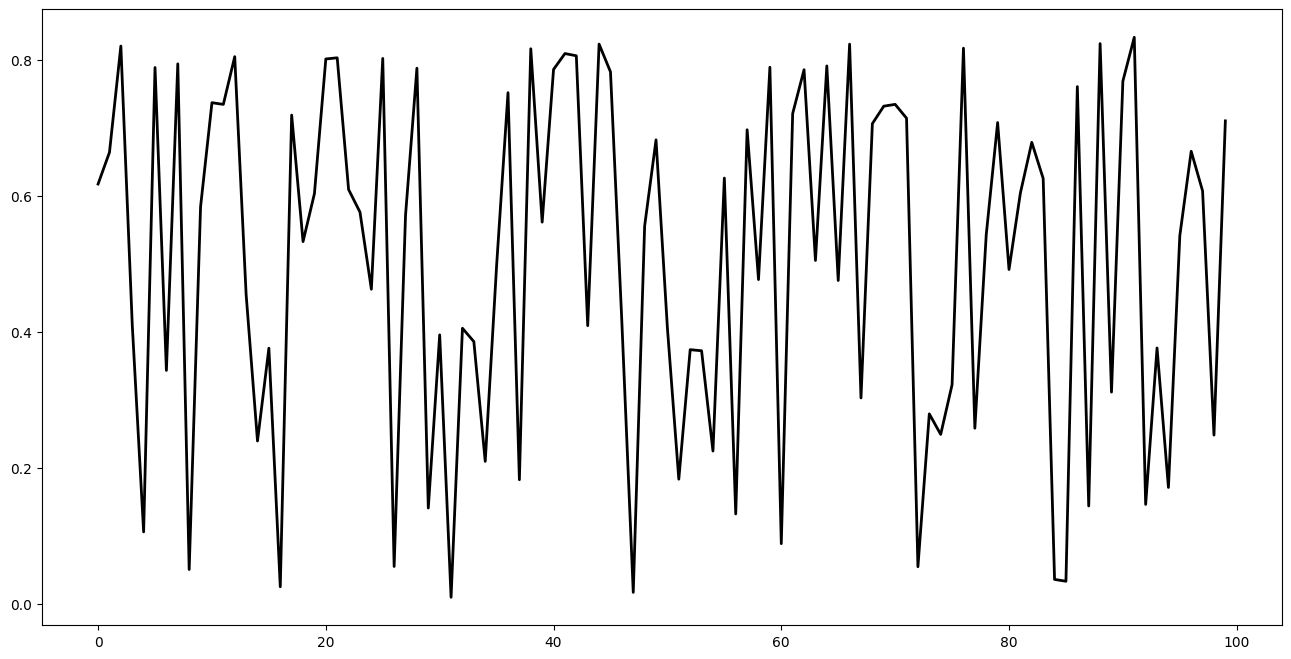

c_k[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_cs[0,0,:]:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
coefficients check: False

y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

In [13]:
test_reconstruction(
    the_measure="lmu", lambda_n=2.0, alpha=0.0, discretization=0.0, print_all=print_all
)

#### LagT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lagt LTI model with 0.0 transform

Testing BRYANS HiPPO-lagt model
Creating HiPPO-lagt LTI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-lagt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


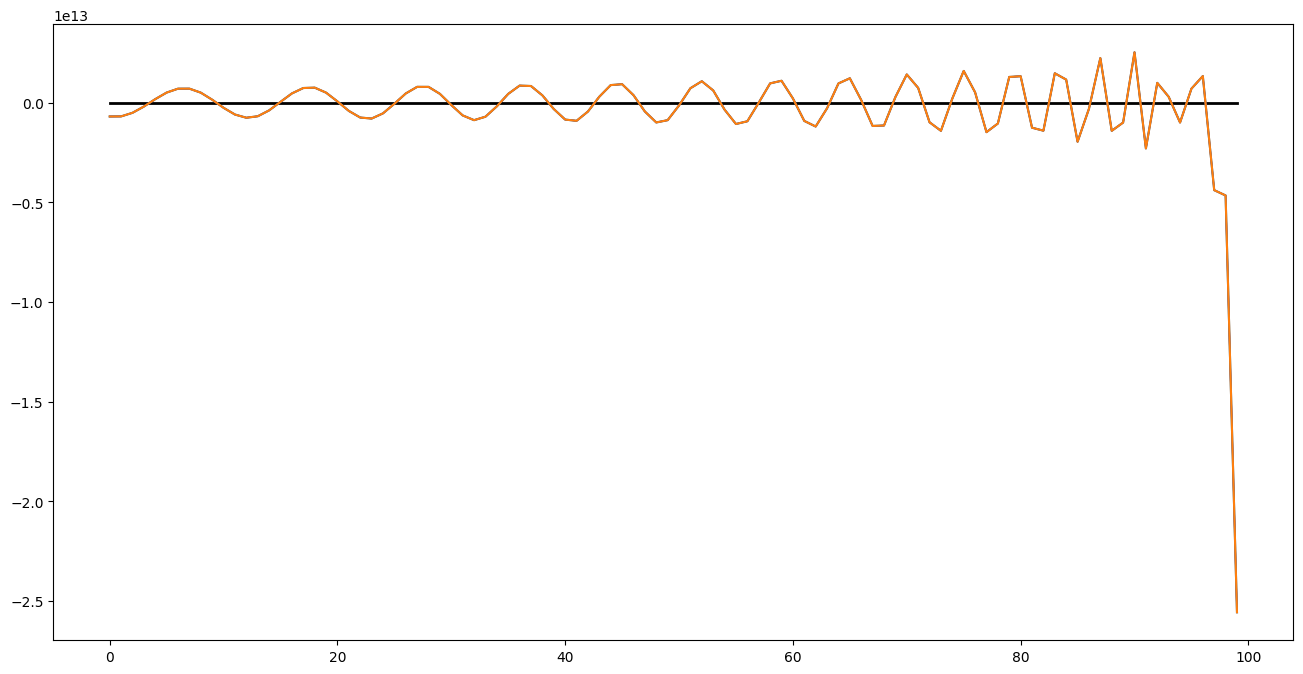

c_k[0,0,:]:
[[ 7.10788667e-01  4.62014049e-01  8.20959330e-01  1.12153220e+00  1.23953331e+00  1.42088437e+00  2.48671889e+00  6.26852894e+00  1.69602985e+01
   4.41389847e+01  1.07811966e+02  2.44487625e+02  5.09739655e+02  9.64562683e+02  1.61485376e+03  2.23578345e+03  1.93882410e+03 -1.79610876e+03
  -1.51294570e+04 -5.17726328e+04 -1.40164219e+05 -3.35913375e+05 -7.42193125e+05 -1.54123075e+06 -3.03969875e+06 -5.72847450e+06 -1.03505960e+07
  -1.79570240e+07 -2.99035620e+07 -4.77036480e+07 -7.26212320e+07 -1.04923840e+08 -1.43047680e+08 -1.84009344e+08 -2.29378848e+08 -3.08168896e+08
  -5.43199424e+08 -1.31775770e+09 -3.65520333e+09 -1.00191427e+10 -2.58879529e+10 -6.26541855e+10 -1.42600405e+11 -3.06776048e+11 -6.26226168e+11
  -1.21566331e+12 -2.24564793e+12 -3.94447762e+12 -6.57705665e+12 -1.03980361e+13]]
gu_cs[0,0,:]:
[ 7.1078867e-01  4.6201405e-01  8.2095933e-01  1.1215322e+00  1.2395333e+00  1.4208844e+00  2.4867191e+00  6.2685299e+00  1.6960299e+01
  4.4138981e+01  1.07811

In [14]:
test_reconstruction(
    the_measure="lagt", lambda_n=1.0, alpha=0.0, discretization=0.0, print_all=print_all
)

#### FRU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fru LTI model with 0.0 transform

Testing BRYANS HiPPO-fru model
Creating HiPPO-fru LTI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-fru
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


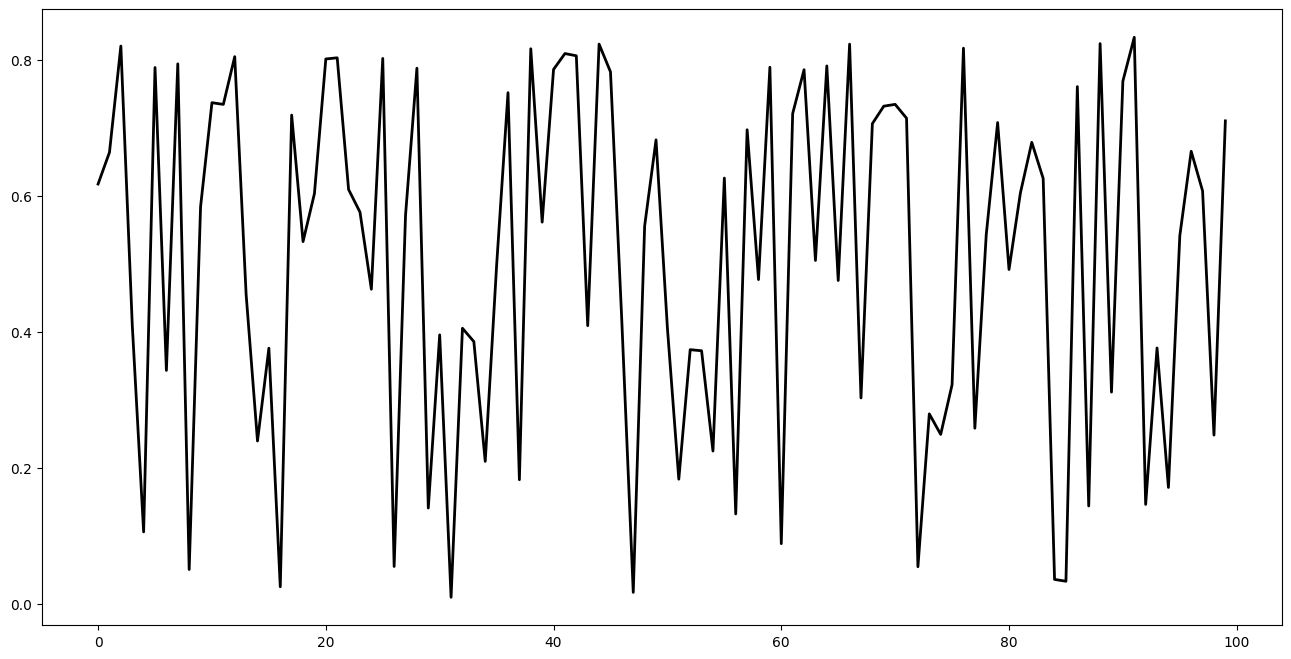

c_k[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_cs[0,0,:]:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
coefficients check: False

y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

In [15]:
test_reconstruction(
    the_measure="fru", lambda_n=1.0, alpha=0.0, discretization=0.0, print_all=print_all
)

#### FouT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fout LTI model with 0.0 transform

Testing BRYANS HiPPO-fout model
Creating HiPPO-fout LTI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-fout
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


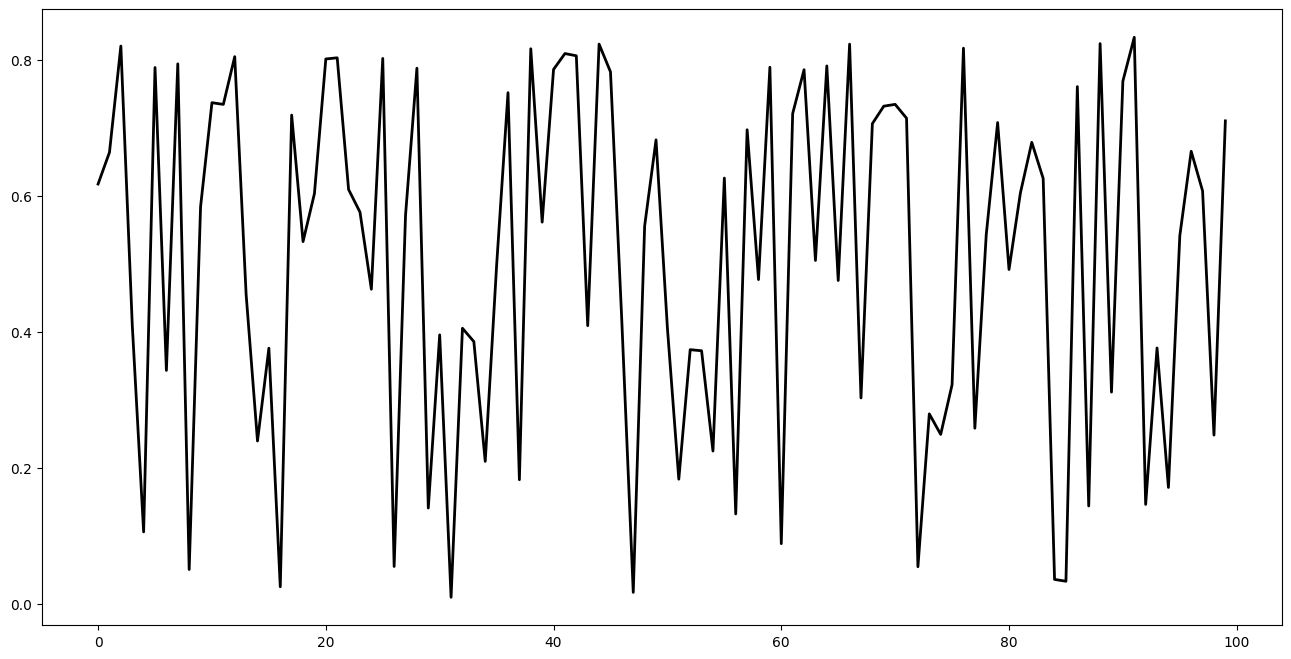

c_k[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_cs[0,0,:]:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
coefficients check: False

y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

In [16]:
test_reconstruction(
    the_measure="fout", lambda_n=1.0, alpha=0.0, discretization=0.0, print_all=print_all
)

#### FouD

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-foud LTI model with 0.0 transform

Testing BRYANS HiPPO-foud model
Creating HiPPO-foud LTI model with 0.0 transform
Bryan's Coeffiecients for 0.0 LTI HiPPO-foud
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


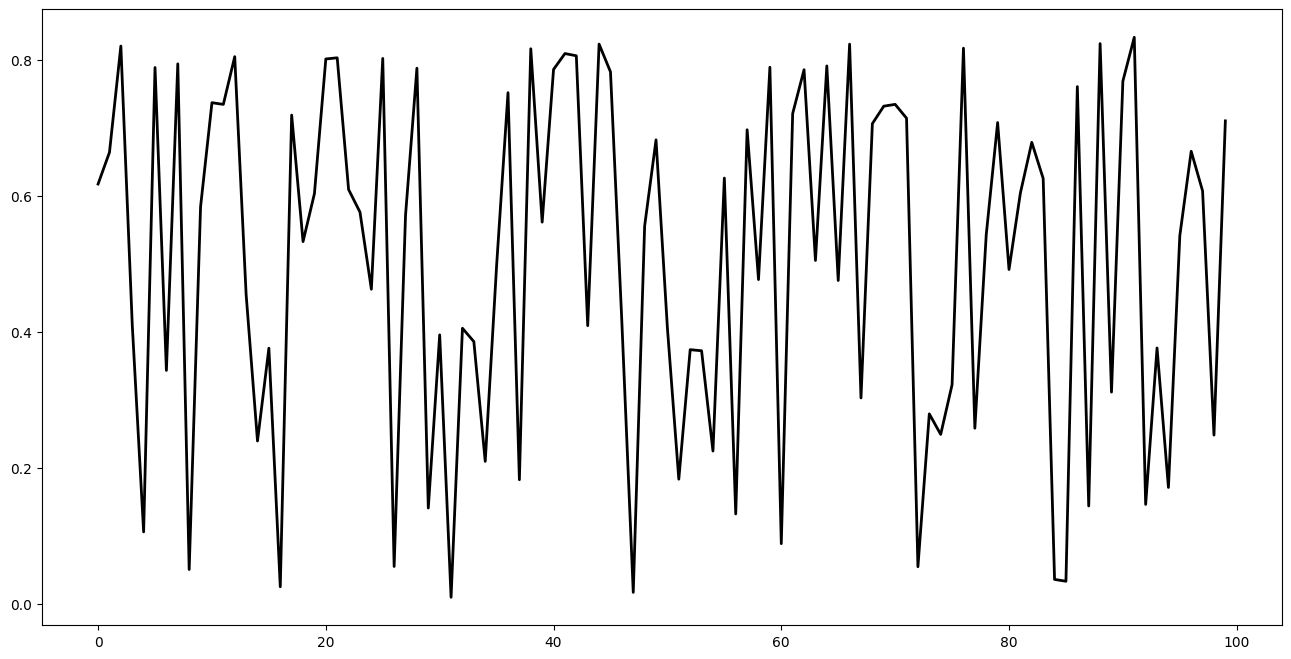

c_k[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_cs[0,0,:]:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
coefficients check: False

y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
gu_y[0,0,:]:
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

In [17]:
test_reconstruction(
    the_measure="foud", lambda_n=1.0, alpha=0.0, discretization=0.0, print_all=print_all
)

### Testing (LTI and LSI) Operators With Backward Euler Transform

#### LegS

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legs LTI model with 1.0 transform
Creating Gu's HiPPO-legs LSI model with 1.0 transform

Testing BRYANS HiPPO-legs model
Creating HiPPO-legs LTI model with 1.0 transform
Creating HiPPO-legs LSI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-legs
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


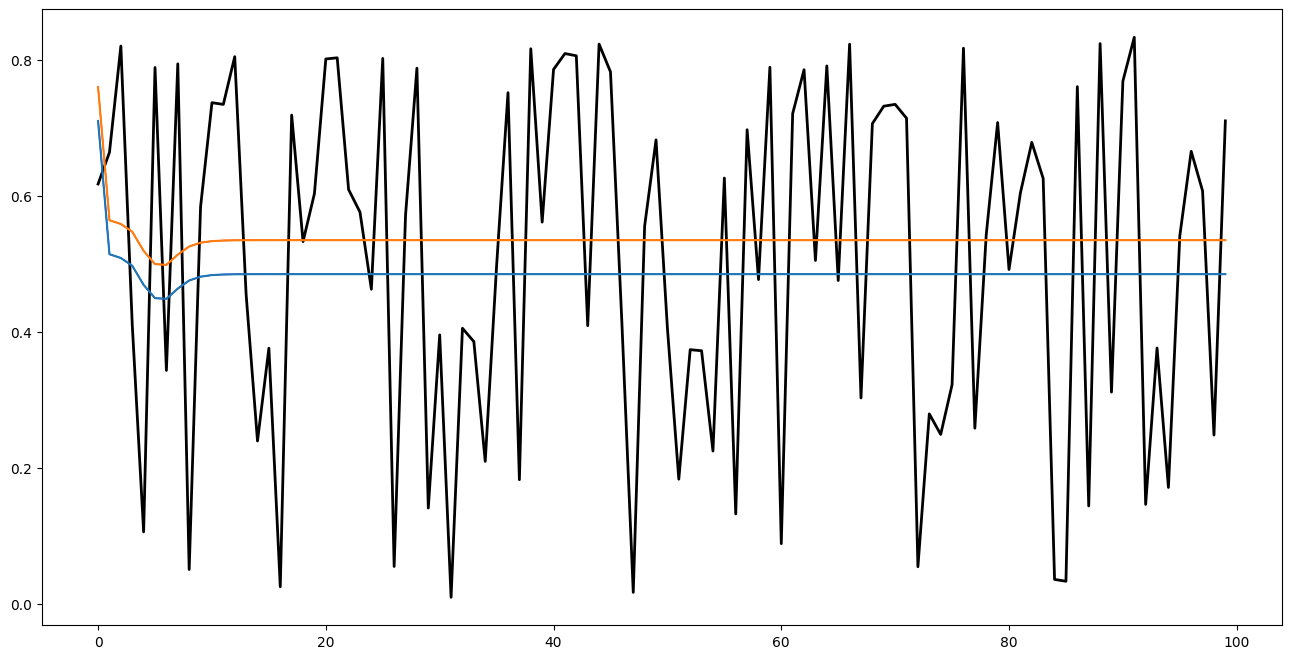

c_k[0,0,:]:
[[ 5.61124086e-01  6.04809076e-02  1.93553381e-02  3.58994026e-03 -4.95413784e-03  3.64076812e-03 -2.34862114e-03  1.41403242e-03 -7.84971227e-04
   3.71123751e-04 -1.01990561e-04 -7.08564185e-05  1.79517941e-04 -2.46049167e-04  2.84205424e-04 -3.03115434e-04  3.09441006e-04 -3.07479786e-04
   3.00039217e-04 -2.89218035e-04  2.76140840e-04 -2.61875626e-04  2.47310876e-04 -2.32838240e-04  2.18696077e-04 -2.04777956e-04  1.91291590e-04
  -1.78655566e-04  1.66839003e-04 -1.55677611e-04  1.45073936e-04 -1.35045906e-04  1.25562612e-04 -1.16683943e-04  1.08412874e-04 -1.00806734e-04
   9.36291399e-05 -8.69982396e-05  8.08860204e-05 -7.50895415e-05  6.97093201e-05 -6.46870540e-05  5.99071354e-05 -5.54140461e-05  5.11857579e-05
  -4.72848042e-05  4.36841874e-05 -4.03348386e-05  3.71577444e-05 -3.42735984e-05]]
gu_cs[0,0,:]:
[ 5.6112796e-01  6.0476288e-02  1.9358380e-02  3.5885721e-03 -4.9534580e-03  3.6402524e-03 -2.3485161e-03  1.4140379e-03 -7.8498223e-04
  3.7145271e-04 -1.02740

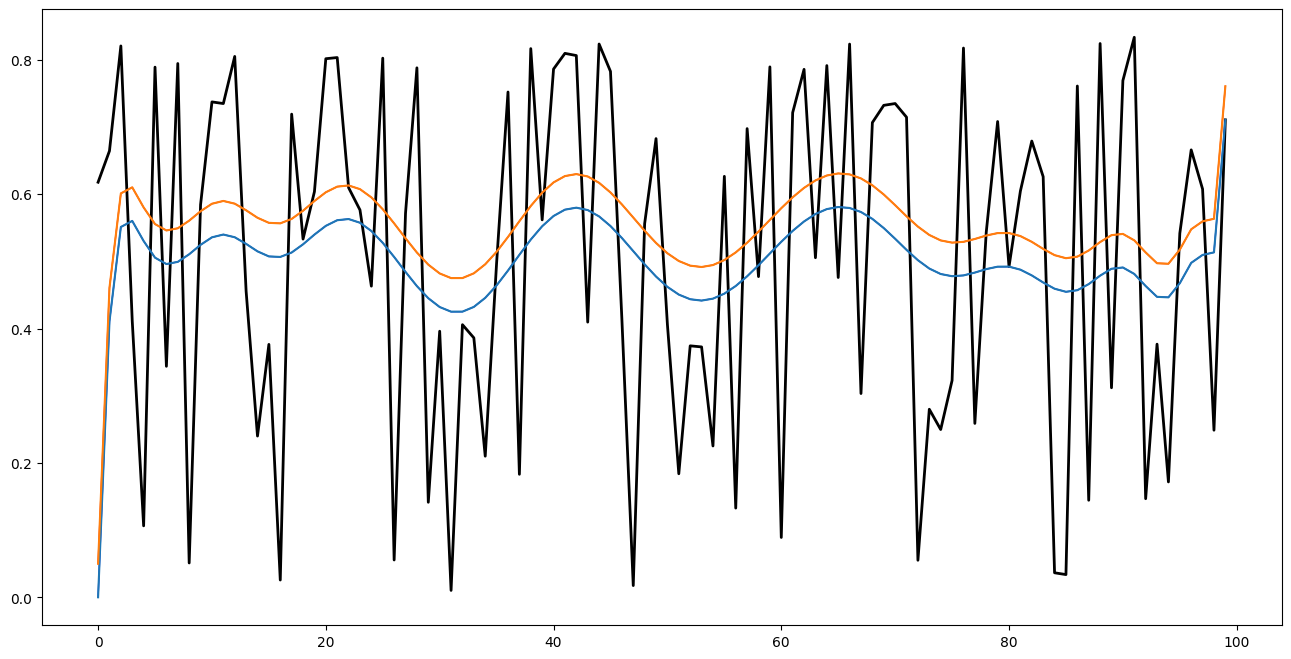

c_k[0,0,:,:]:
[[ 3.0897772e-01  1.7839052e-01 -7.8615716e-07 -9.3233865e-08  5.0300247e-07 -4.4660172e-07  5.8990565e-07 -6.0314255e-07  5.6861148e-07
  -8.5176617e-07  1.1280147e-06 -1.2845555e-06  1.0819732e-06 -1.0704629e-06  1.1142023e-06 -9.1507314e-07  8.1263096e-07 -7.9824304e-07
   7.1133985e-07 -6.1868150e-07  4.4660172e-07 -1.8416566e-07  9.3809383e-08 -2.2330086e-07  3.7178444e-07 -2.5092572e-07 -1.4387942e-09
   4.1437275e-08  1.0934836e-07 -2.5840745e-07  2.7739952e-07 -2.0373326e-07  7.7694885e-08  6.5609015e-08 -1.8876980e-07  1.7495738e-07
  -2.0718637e-07  1.9222291e-07 -1.1970768e-07  1.4272838e-07 -1.4272838e-07  1.3582218e-07 -2.0718637e-07  2.8775884e-07 -3.8214375e-07
   3.8674790e-07 -3.3149820e-07  2.8545676e-07 -3.1768576e-07  2.7624850e-07]]
gu_cs[0,0,:,:]:
[[ 3.08978707e-01  1.78388938e-01 -3.25951643e-09 -7.90635912e-09  1.70544165e-08 -7.96249466e-09 -2.28856445e-09  4.85322005e-10  5.95173466e-09
  -1.40523078e-08  1.23857031e-08  4.77463447e-09 -7.6953181

In [18]:
test_reconstruction(
    the_measure="legs", lambda_n=1.0, alpha=1.0, discretization=1.0, print_all=print_all
)

#### LegT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legt LTI model with 1.0 transform

Testing BRYANS HiPPO-legt model
Creating HiPPO-legt LTI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-legt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


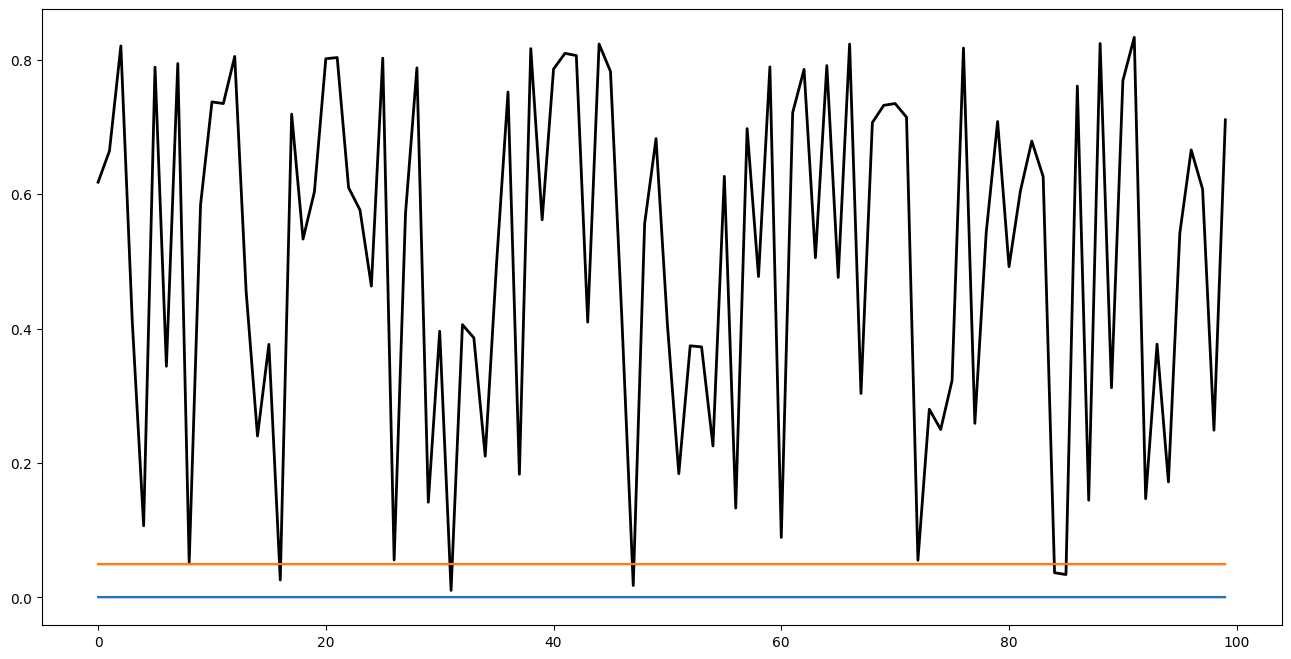

c_k[0,0,:]:
[[ 5.78606009e-01  5.34732640e-02  1.50594776e-02  2.04746309e-03  1.49528525e-04  7.44251884e-06  1.43801628e-08  7.99629518e-09  1.98352978e-07
  -1.64754908e-07  2.41132518e-08  7.28730782e-08 -1.30976829e-07  4.47312445e-08 -4.57820022e-08 -4.57142733e-08  1.88665545e-08 -1.93377936e-08
   8.36961220e-08 -1.59710503e-08 -3.83963403e-08  9.87003332e-08 -5.44297549e-08 -1.96159924e-08  5.77701442e-08 -3.68845328e-08 -2.96725329e-08
   7.20411890e-08 -3.40176882e-08  5.62752822e-09  2.24859775e-08 -4.47644517e-08  1.94118996e-08  3.83321419e-09 -2.11418598e-08 -1.55673199e-08
   9.76728121e-09  3.95132425e-08  1.70577046e-08 -1.31195321e-09 -7.46524442e-09 -2.81727841e-09 -5.64584957e-09  7.77629405e-10 -1.35815394e-08
  -1.13007514e-09 -1.61870055e-08 -5.61319169e-09 -3.55180685e-09 -5.85737103e-09]]
gu_cs[0,0,:]:
[ 5.78608453e-01  5.34722880e-02  1.50588090e-02  2.04771338e-03  1.49428684e-04  7.12788869e-06  3.40001236e-07  2.53398795e-08  2.33739272e-09
  1.34100300e-1

In [19]:
test_reconstruction(
    the_measure="legt", lambda_n=1.0, alpha=1.0, discretization=1.0, print_all=print_all
)

#### LMU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lmu LTI model with 1.0 transform

Testing BRYANS HiPPO-lmu model
Creating HiPPO-lmu LTI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-lmu
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


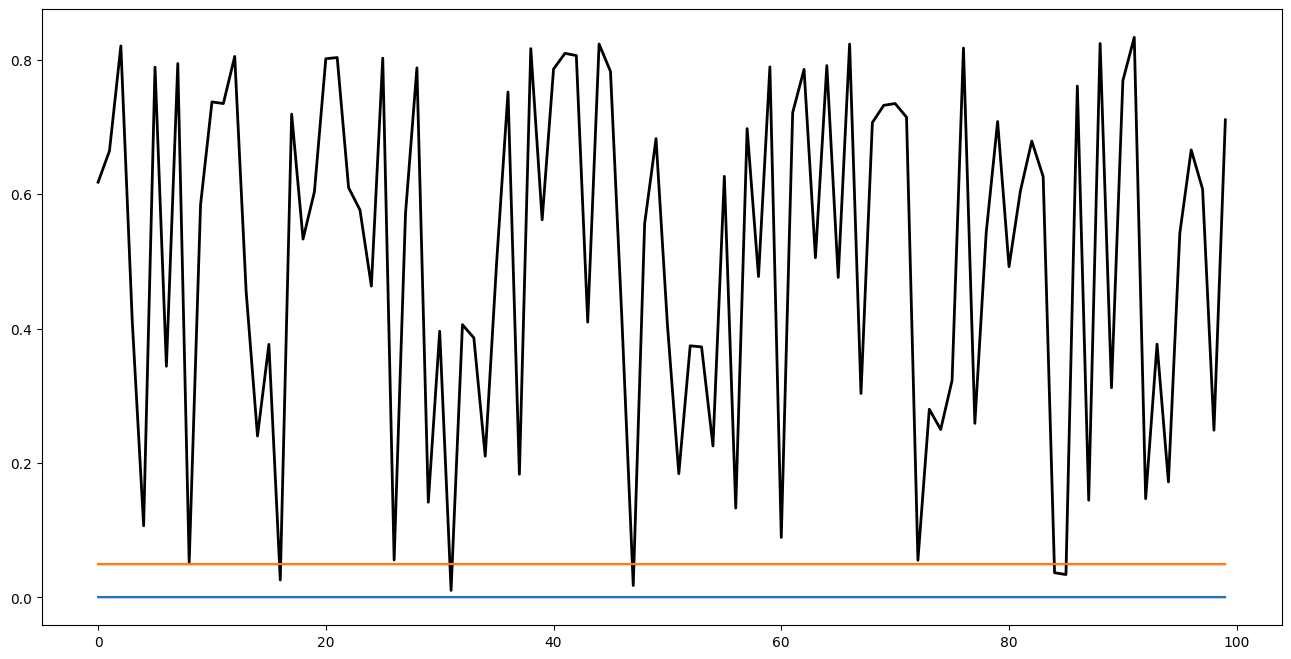

c_k[0,0,:]:
[[ 5.78622103e-01 -9.26085860e-02  3.36645208e-02 -5.42240636e-03  4.47708706e-04 -2.22124509e-05  2.23341976e-06  1.27876046e-06  1.21587095e-06
   5.63341075e-07 -7.66894402e-07 -1.21854032e-06 -5.35302092e-07  1.07735843e-07  5.78600691e-07  7.99834936e-07 -2.08452207e-07 -4.34633137e-07
  -2.77163281e-07  1.48395145e-08  8.17820123e-08  8.32798506e-08 -1.84188576e-08  2.60070010e-07 -1.79172090e-07 -3.46139018e-07  4.33081038e-09
   5.60477993e-08 -6.10751911e-08 -4.76456421e-08  1.93894621e-07 -2.81442016e-08 -4.25730562e-08  2.49541472e-07 -1.16065124e-07 -2.66997915e-07
  -1.34164377e-08  1.00611715e-07 -1.49628789e-08  6.82685020e-10  4.25733049e-08 -1.56874293e-07  4.73551651e-08  2.42450142e-07 -3.85595413e-08
  -1.04781321e-07  3.05632533e-08  2.59825068e-08 -1.53181446e-07  1.01415836e-07]]
gu_cs[0,0,:]:
[ 5.7860845e-01 -9.2616707e-02  3.3672512e-02 -5.4177367e-03  4.4828563e-04 -2.3642098e-05  1.2284559e-06 -9.6822731e-08  8.8679073e-09
 -7.2575684e-10  5.05475

In [20]:
test_reconstruction(
    the_measure="lmu", lambda_n=2.0, alpha=1.0, discretization=1.0, print_all=print_all
)

#### LagT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lagt LTI model with 1.0 transform

Testing BRYANS HiPPO-lagt model
Creating HiPPO-lagt LTI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-lagt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


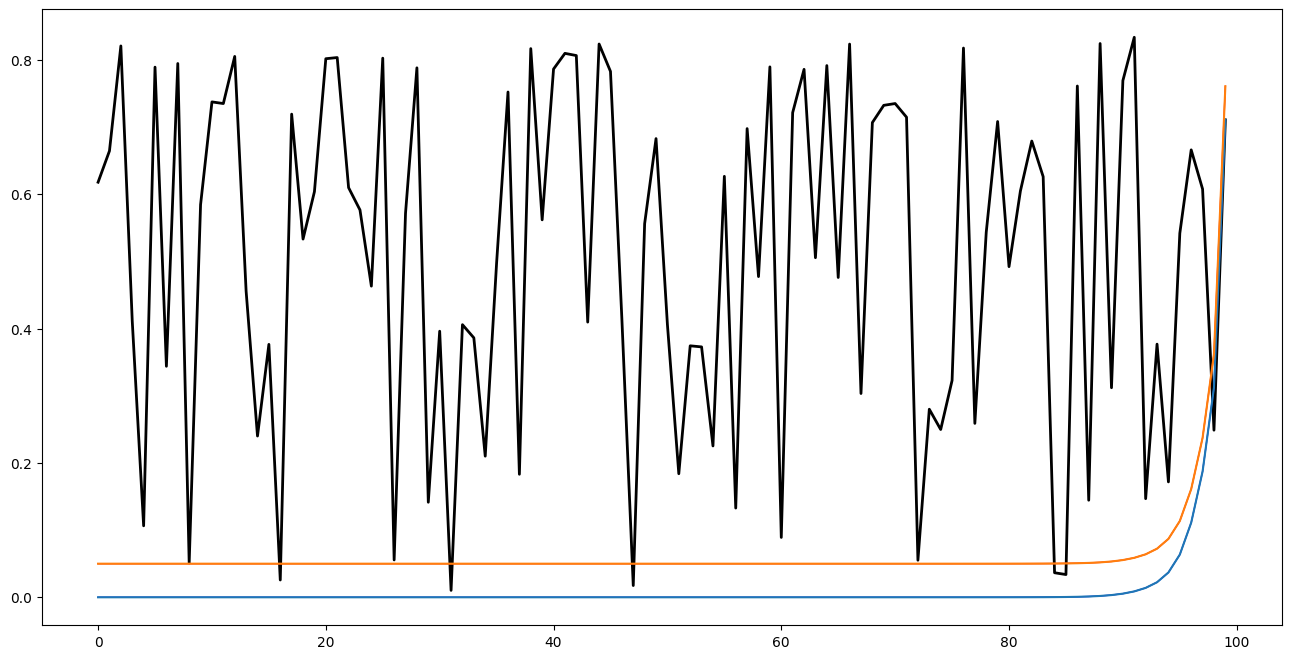

c_k[0,0,:]:
[[ 5.61128438e-01  4.73748744e-02  2.76702791e-02  2.04521194e-02  1.73221529e-02  1.41570698e-02  1.02901896e-02  6.49252441e-03  3.52383917e-03
   1.62014086e-03  6.03723456e-04  1.55663249e-04  4.91847459e-06 -2.49443510e-05 -1.57141349e-05 -2.54362112e-06  4.77371623e-06  6.78308970e-06
   6.62870843e-06  6.13633483e-06  3.79104085e-06  2.75234834e-06  1.61969740e-06  1.07541598e-06  4.29354344e-07  5.30150288e-08  5.80491928e-07
   2.12183281e-07  5.25744895e-07 -2.76502590e-07  3.95304596e-07 -2.49297415e-07  1.01817335e-07 -7.87443071e-08  2.20593222e-07  2.45502548e-07
   9.67959650e-08 -1.88566148e-07  2.29539950e-07 -2.15822681e-07  3.35245545e-07 -3.86555058e-07  1.10420046e-07  4.07709280e-08 -2.91131698e-07
   4.99957594e-07 -1.31721066e-07 -1.39001429e-07  1.80782166e-07 -3.57084566e-08]]
gu_cs[0,0,:]:
[ 5.6112796e-01  4.7375306e-02  2.7670756e-02  2.0452168e-02  1.7322019e-02  1.4157327e-02  1.0289848e-02  6.4923549e-03  3.5243188e-03
  1.6203343e-03  6.03263

In [21]:
test_reconstruction(
    the_measure="lagt", lambda_n=1.0, alpha=1.0, discretization=1.0, print_all=print_all
)

#### FRU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fru LTI model with 1.0 transform

Testing BRYANS HiPPO-fru model
Creating HiPPO-fru LTI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-fru
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


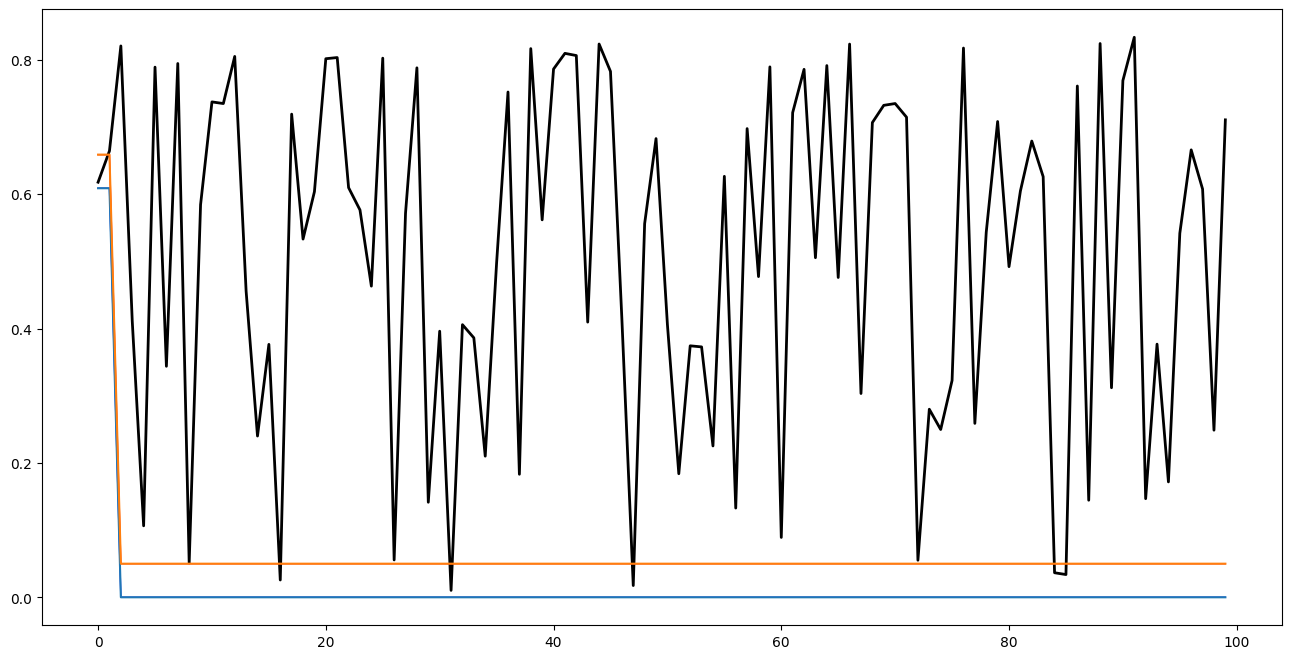

c_k[0,0,:]:
[[5.44093370e-01 4.46309859e-05 2.62938999e-02 2.87625417e-02 7.89105520e-03 2.05815323e-02 3.62322433e-03 1.45729873e-02 2.06132280e-03
  1.11587569e-02 1.32622407e-03 9.01251100e-03 9.23615298e-04 7.54934084e-03 6.79746736e-04 6.49100356e-03 5.21010370e-04 5.69108035e-03
  4.11979825e-04 5.06575033e-03 3.33894102e-04 4.56366595e-03 2.76047038e-04 4.15182672e-03 2.32043443e-04 3.80795682e-03 1.97754969e-04
  3.51655763e-03 1.70538959e-04 3.26650403e-03 1.48579114e-04 3.04957805e-03 1.30604079e-04 2.85961805e-03 1.15712435e-04 2.69191153e-03
  1.03217935e-04 2.54276535e-03 9.26446955e-05 2.40925327e-03 8.36229956e-05 2.28905026e-03 7.58479728e-05 2.18025874e-03 6.91011155e-05
  2.08133506e-03 6.32337324e-05 1.99099025e-03 5.80802152e-05 1.90815539e-03]]
gu_cs[0,0,:]:
[5.44093728e-01 0.00000000e+00 2.62938999e-02 2.87624002e-02 7.89095741e-03 2.05814242e-02 3.62324854e-03 1.45729892e-02 2.06136610e-03
 1.11586992e-02 1.32622523e-03 9.01250169e-03 9.23621759e-04 7.54931755e-0

In [22]:
test_reconstruction(
    the_measure="fru", lambda_n=1.0, alpha=1.0, discretization=1.0, print_all=print_all
)

#### FouT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fout LTI model with 1.0 transform

Testing BRYANS HiPPO-fout model
Creating HiPPO-fout LTI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-fout
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


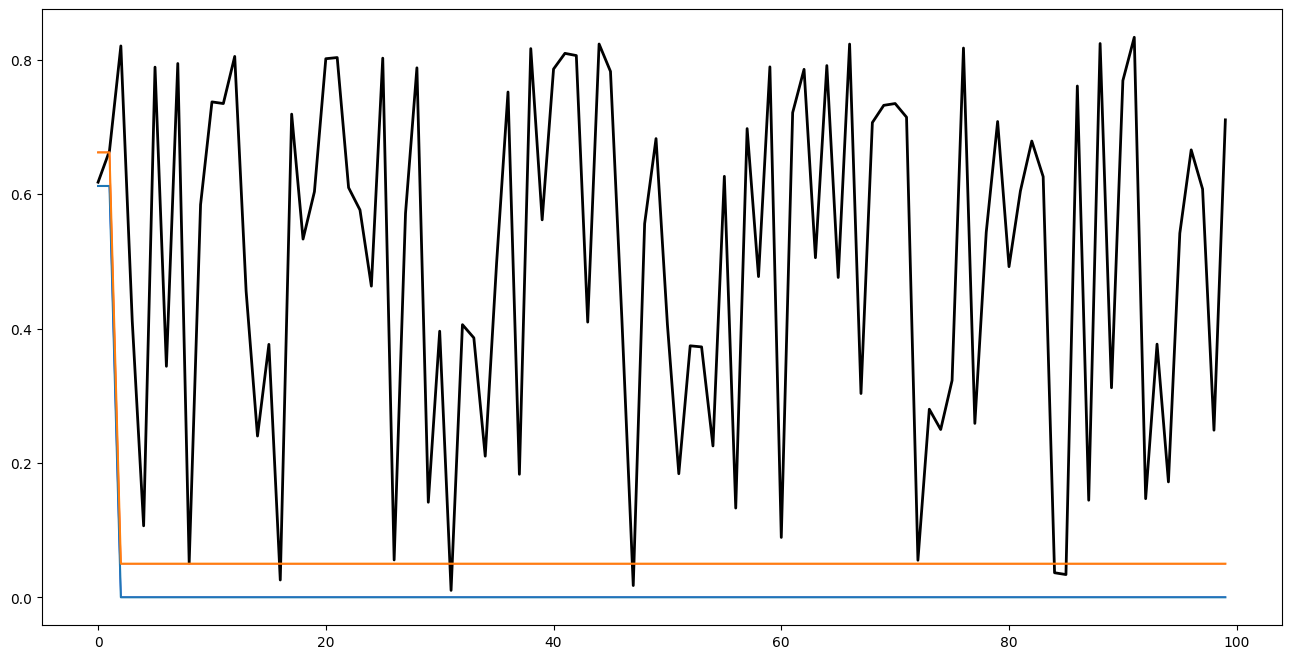

c_k[0,0,:]:
[[ 5.7900518e-01 -9.0312342e-06  1.4470153e-02  4.0596601e-02  3.7455601e-03  2.1684328e-02  1.6755633e-03  1.4631597e-02  9.4456854e-04
   1.1019984e-02  6.0517550e-04  8.8331448e-03  4.2053006e-04  7.3687313e-03  3.0906583e-04  6.3201180e-03  2.3666401e-04  5.5323518e-03
   1.8703639e-04  4.9190400e-03  1.5149718e-04  4.4280146e-03  1.2521989e-04  4.0260800e-03  1.0521736e-04  3.6910283e-03  8.9672962e-05
   3.4073996e-03  7.7319542e-05  3.1642136e-03  6.7346919e-05  2.9534388e-03  5.9183541e-05  2.7689782e-03  5.2430427e-05  2.6061968e-03
   4.6785117e-05  2.4614967e-03  4.1982421e-05  2.3320105e-03  3.7885129e-05  2.2154595e-03  3.4365239e-05  2.1100061e-03  3.1314157e-05
   2.0141280e-03  2.8657791e-05  1.9265844e-03  2.6306692e-05  1.8463270e-03]]
gu_cs[0,0,:]:
[5.7900393e-01 0.0000000e+00 1.4470046e-02 4.0597010e-02 3.7456003e-03 2.1684606e-02 1.6755108e-03 1.4631761e-02 9.4461290e-04 1.1020099e-02
 6.0518703e-04 8.8332500e-03 4.2050853e-04 7.3688235e-03 3.0905128e-0

In [23]:
test_reconstruction(
    the_measure="fout", lambda_n=1.0, alpha=1.0, discretization=1.0, print_all=print_all
)

#### FouD

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-foud LTI model with 1.0 transform

Testing BRYANS HiPPO-foud model
Creating HiPPO-foud LTI model with 1.0 transform
Bryan's Coeffiecients for 1.0 LTI HiPPO-foud
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


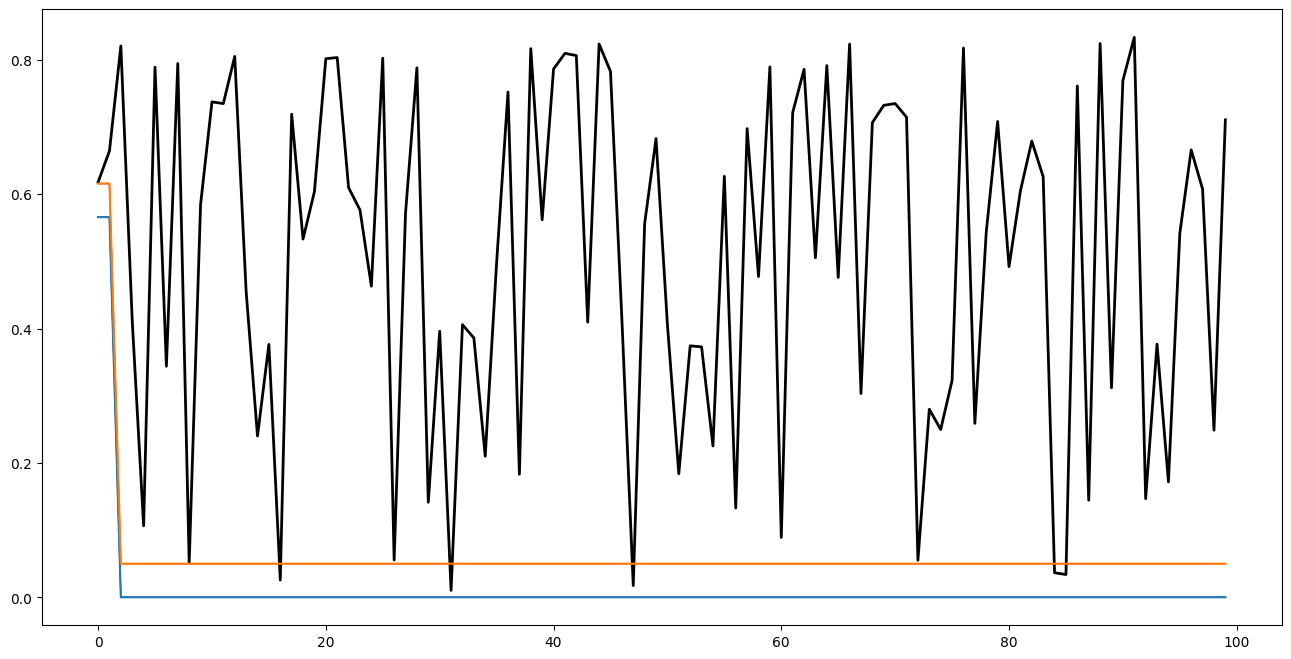

c_k[0,0,:]:
[[5.2357852e-01 2.2923303e-05 1.7131865e-02 2.1460295e-02 5.1714843e-03 1.4764566e-02 2.3771604e-03 1.0402035e-02 1.3529597e-03 7.9520307e-03
  8.7059522e-04 6.4178361e-03 6.0637417e-04 5.3738132e-03 4.4630413e-04 4.6193618e-03 3.4208290e-04 4.0494790e-03 2.7049225e-04 3.6041313e-03
  2.1923878e-04 3.2466967e-03 1.8126331e-04 2.9535354e-03 1.5235269e-04 2.7088057e-03 1.2984633e-04 2.5014426e-03 1.1198478e-04 2.3234938e-03
  9.7562915e-05 2.1691481e-03 8.5758889e-05 2.0340094e-03 7.5986944e-05 1.9146830e-03 6.7772584e-05 1.8085837e-03 6.0836966e-05 1.7136086e-03
  5.4902543e-05 1.6280923e-03 4.9802300e-05 1.5507110e-03 4.5386856e-05 1.4803354e-03 4.1529431e-05 1.4160669e-03 3.8138700e-05 1.3571479e-03]]
gu_cs[0,0,:]:
[5.2357984e-01 0.0000000e+00 1.7131913e-02 2.1460071e-02 5.1715076e-03 1.4764432e-02 2.3771585e-03 1.0401957e-02 1.3529467e-03 7.9519264e-03
 8.7060139e-04 6.4177923e-03 6.0637004e-04 5.3737452e-03 4.4628920e-04 4.6193274e-03 3.4208482e-04 4.0494539e-03 2.705031

In [24]:
test_reconstruction(
    the_measure="foud", lambda_n=1.0, alpha=1.0, discretization=1.0, print_all=print_all
)

### Testing (LTI and LSI) Operators With Bidirectional Transform

#### LegS

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legs LTI model with 0.5 transform
Creating Gu's HiPPO-legs LSI model with 0.5 transform

Testing BRYANS HiPPO-legs model
Creating HiPPO-legs LTI model with 0.5 transform
Creating HiPPO-legs LSI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-legs
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


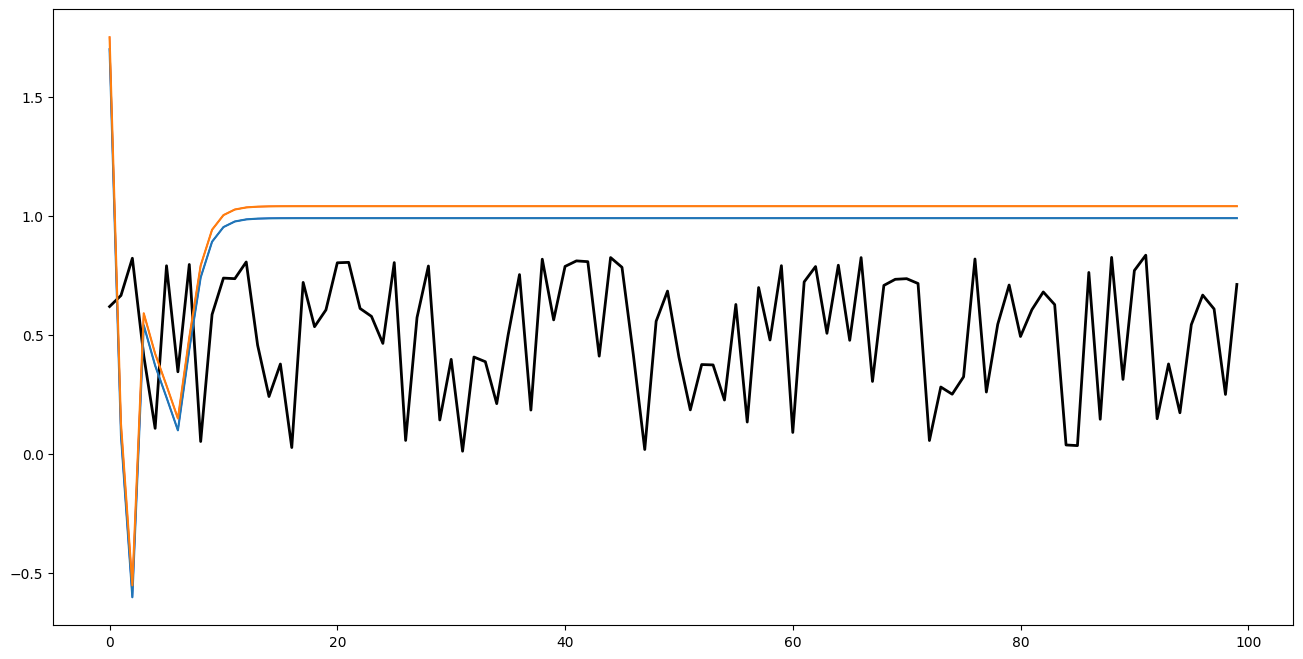

c_k[0,0,:]:
[[ 0.596044    0.19874386  0.21850152  0.03550711  0.08243275  0.19277443 -0.1459328  -0.3994286  -0.11207076  0.15447251 -0.1530843  -0.06512478
   0.0926576   0.07993614  0.17285424 -0.19829917 -0.42689914  0.11740014  0.30691493  0.17461419  0.19483326 -0.11992959 -0.07320458  0.06061407
  -0.01546875  0.031695   -0.04632376  0.01644013  0.03059876 -0.05312014  0.04009525 -0.0095523  -0.0145256   0.01962666 -0.00779294 -0.01063595
   0.0250257  -0.02943919  0.02357724 -0.01114051 -0.00274682  0.01369624 -0.0192152   0.0188811  -0.01388771  0.00632855  0.00157777 -0.00802401
   0.01187483 -0.01272418]]
gu_cs[0,0,:]:
[ 0.59604394  0.19874366  0.2185032   0.03550642  0.08243041  0.19277538 -0.14593063 -0.399431   -0.11207143  0.15446806 -0.15308447 -0.06512605
  0.09265915  0.07993677  0.17285256 -0.19829953 -0.42689982  0.11739708  0.306921    0.17461927  0.1948349  -0.11992584 -0.0731981   0.06062178
 -0.01546822  0.03168819 -0.04632478  0.01643778  0.03059826 -0.05312883

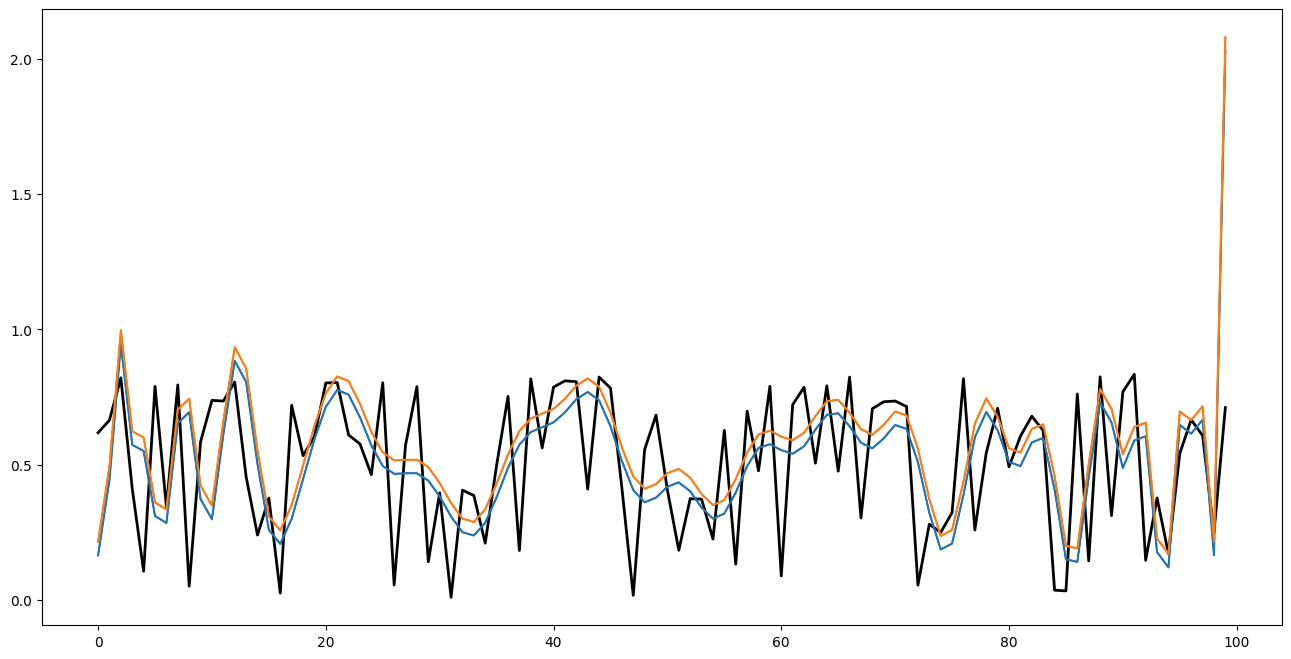

c_k[0,0,:,:]:
[[ 4.11971450e-01  3.56777787e-01  9.21196267e-02 -4.88039007e-07  1.79561516e-06 -9.70322844e-07 -6.54939129e-07  4.41997599e-07 -5.82423922e-07
   7.27454335e-07 -1.05319737e-06  1.18096227e-06 -7.27454335e-07  7.85006137e-07 -9.73775968e-07  6.90621249e-09  5.54799044e-07 -4.82283838e-07
   1.22009752e-07  3.55669926e-07 -9.20828313e-07  1.30297201e-06 -1.08024665e-06  1.01981732e-06 -9.82984261e-07  9.13922065e-07 -9.36367258e-07
   1.09578571e-06 -1.03823390e-06  9.00109683e-07 -8.34500668e-07  8.26443397e-07 -9.09317976e-07  8.69031737e-07 -8.44859983e-07  8.21839251e-07
  -6.29616352e-07  3.47612684e-07 -4.71924508e-08 -3.91352017e-08 -2.41717437e-08  1.33520103e-07 -2.80852646e-07  3.59123050e-07 -3.52216830e-07
   2.71644353e-07 -1.88769803e-07  1.01291114e-07 -7.36662642e-08  0.00000000e+00]]
gu_cs[0,0,:,:]:
[[ 4.11971629e-01  3.56777877e-01  9.21196416e-02 -1.19241879e-08  2.09852313e-08 -1.87168547e-09 -1.53677693e-08  8.64413874e-09  4.23887769e-09
  -1.94398

In [25]:
test_reconstruction(
    the_measure="legs", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=print_all
)

#### LegT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legt LTI model with 0.5 transform

Testing BRYANS HiPPO-legt model
Creating HiPPO-legt LTI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-legt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


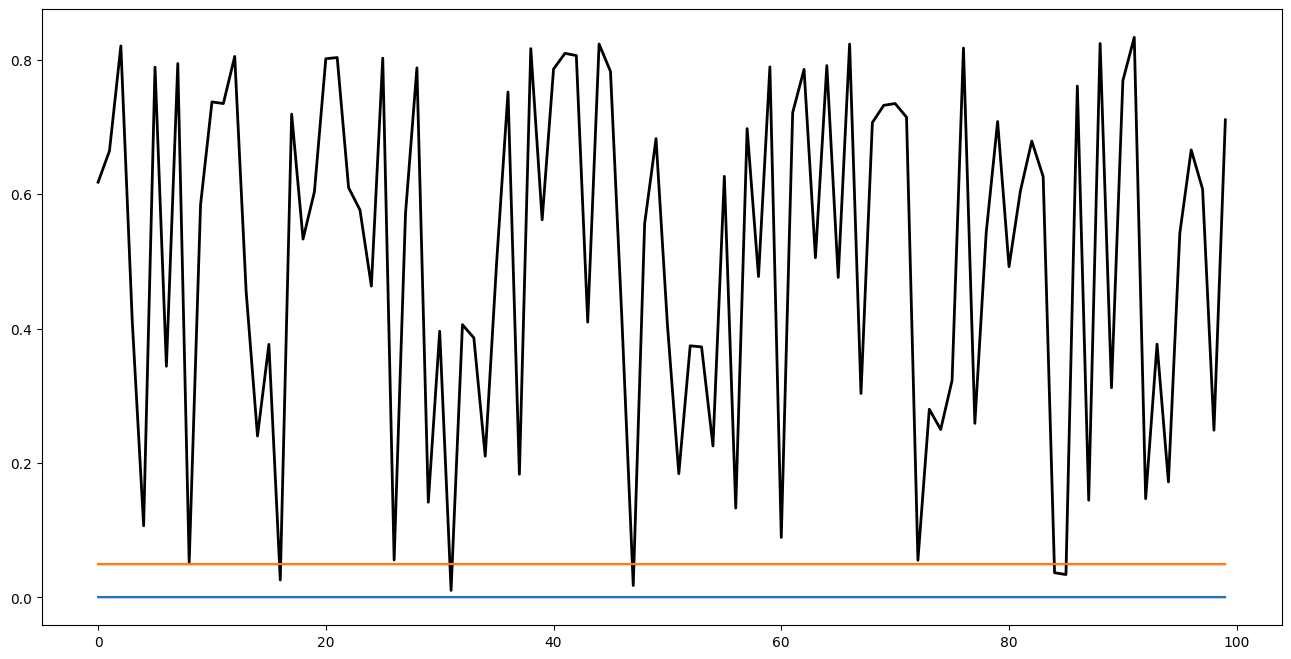

c_k[0,0,:]:
[[ 5.8287817e-01  3.5734659e-01 -8.7148130e-02  2.0945090e-01  3.7911367e-01 -2.0972927e-01 -3.3950734e-01  3.1806514e-02 -7.1527329e-03
  -2.9997611e-01 -1.5191761e-01  2.8662404e-01  2.8327519e-01 -1.2870894e-01 -3.3108848e-01 -1.5514165e-01  9.3101382e-02  1.8854336e-01
   1.5212305e-01  8.2987614e-02  3.4493264e-02  1.1480474e-02  3.1333694e-03  7.0918247e-04  1.2944786e-04  1.6178776e-05 -2.3537170e-06
   1.8035818e-06 -2.2523664e-06 -5.4601560e-07  2.9126822e-06 -2.2282709e-06  1.3260491e-07  4.9698070e-07  4.3949424e-07  7.2822297e-07
  -2.1721723e-06  2.9641947e-06  3.1059149e-06 -7.1642677e-07 -3.6373464e-08 -2.6680366e-06 -1.5972589e-06  2.4850729e-06  1.0096471e-06
   4.0474233e-06 -1.4280496e-06 -1.6641351e-06 -4.6918262e-07 -2.1191854e-06]]
gu_cs[0,0,:]:
[ 5.8287889e-01  3.5734677e-01 -8.7146506e-02  2.0944783e-01  3.7911573e-01 -2.0972838e-01 -3.3950397e-01  3.1808734e-02 -7.1585453e-03
 -2.9998022e-01 -1.5192261e-01  2.8662115e-01  2.8327709e-01 -1.2870377e-0

In [26]:
test_reconstruction(
    the_measure="legt", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=print_all
)

#### LMU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lmu LTI model with 0.5 transform

Testing BRYANS HiPPO-lmu model
Creating HiPPO-lmu LTI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-lmu
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


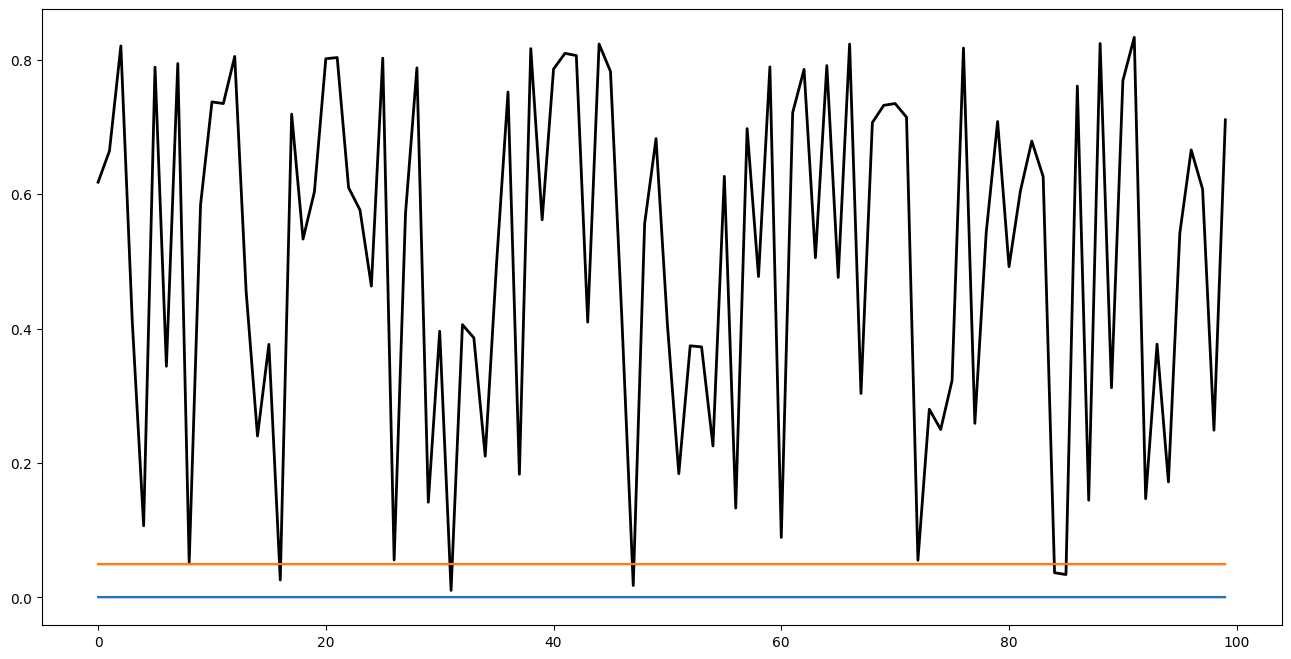

c_k[0,0,:]:
[[ 5.8287859e-01 -6.1892641e-01 -1.9484304e-01 -5.5411088e-01  1.1373279e+00  6.9559729e-01 -1.2240336e+00 -1.2319509e-01 -2.9536953e-02
   1.3075494e+00 -6.9622016e-01 -1.3746613e+00  1.4163574e+00  6.6885513e-01 -1.7828498e+00  8.6382896e-01  5.3477103e-01 -1.1155039e+00
   9.2532974e-01 -5.1824737e-01  2.2082545e-01 -7.5244769e-02  2.1013200e-02 -4.8219757e-03  9.1574364e-04 -1.3446166e-04  2.2687485e-05
  -4.0353179e-06 -1.2199255e-05 -3.3351531e-05 -3.2381190e-06  1.4825903e-06  3.8614908e-06  3.0718398e-05  1.6204009e-05  1.3036978e-05
  -2.2179198e-05 -1.0367323e-05  2.1755814e-05 -8.1801172e-06 -1.8994864e-05 -7.4114259e-06 -1.4660177e-06  7.0813178e-07  8.8937004e-06
   9.6454996e-06 -2.8290353e-06 -1.5808289e-05  9.0321591e-06  2.1953032e-05]]
gu_cs[0,0,:]:
[ 5.82878947e-01 -6.18942618e-01 -1.94865316e-01 -5.54146826e-01  1.13734698e+00  6.95590258e-01 -1.22409868e+00 -1.23195417e-01 -2.95167752e-02
  1.30758429e+00 -6.96195722e-01 -1.37458766e+00  1.41638482e+00 

In [27]:
test_reconstruction(
    the_measure="lmu", lambda_n=2.0, alpha=0.5, discretization=0.5, print_all=print_all
)

#### LagT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lagt LTI model with 0.5 transform

Testing BRYANS HiPPO-lagt model
Creating HiPPO-lagt LTI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-lagt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


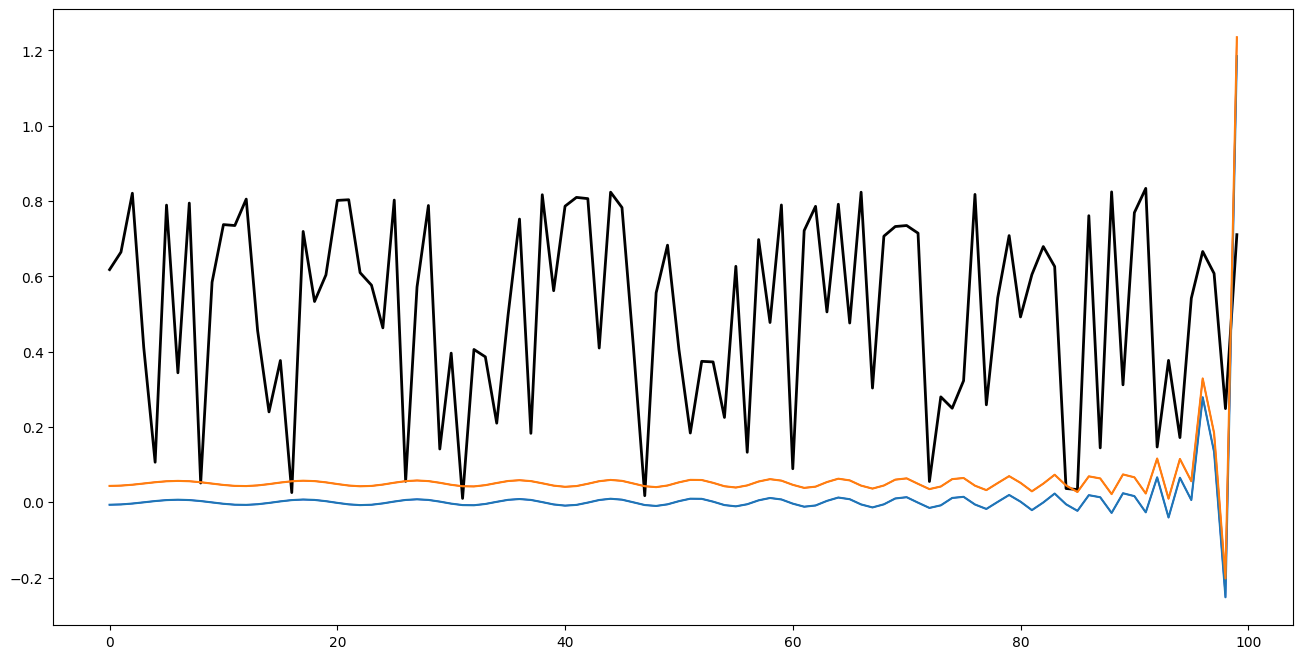

c_k[0,0,:]:
[[ 0.5960439   0.1064004   0.11805524  0.13936919  0.14385024  0.12228702  0.08453335  0.04687917  0.02040602  0.00756557  0.00499771  0.00770417
   0.01174184  0.01505826  0.01724766  0.01894535  0.0212289   0.02513674  0.03131395  0.03982848  0.05014699  0.06127429  0.07198637  0.08109013
   0.0876414   0.09107145  0.09120098  0.08817708  0.08235551  0.07417741  0.06406686  0.05237348  0.03935667  0.0252053   0.01008186 -0.00583356
  -0.0223032  -0.03900628 -0.05554274 -0.0714459  -0.08621928 -0.09937449 -0.11047988 -0.1191979  -0.12531278 -0.12874895 -0.12956475 -0.12794612
  -0.12417252 -0.11859532]]
gu_cs[0,0,:]:
[ 0.59604394  0.10640043  0.1180555   0.13936928  0.14385009  0.12228693  0.0845329   0.04687976  0.02040554  0.00756557  0.00499764  0.00770436
  0.01174179  0.0150585   0.01724783  0.01894498  0.02122898  0.02513652  0.03131403  0.03982818  0.05014697  0.06127451  0.0719861   0.08108962
  0.08764166  0.09107166  0.09120107  0.088177    0.08235577  0.07417734

In [28]:
test_reconstruction(
    the_measure="lagt", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=print_all
)

#### FRU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fru LTI model with 0.5 transform

Testing BRYANS HiPPO-fru model
Creating HiPPO-fru LTI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-fru
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


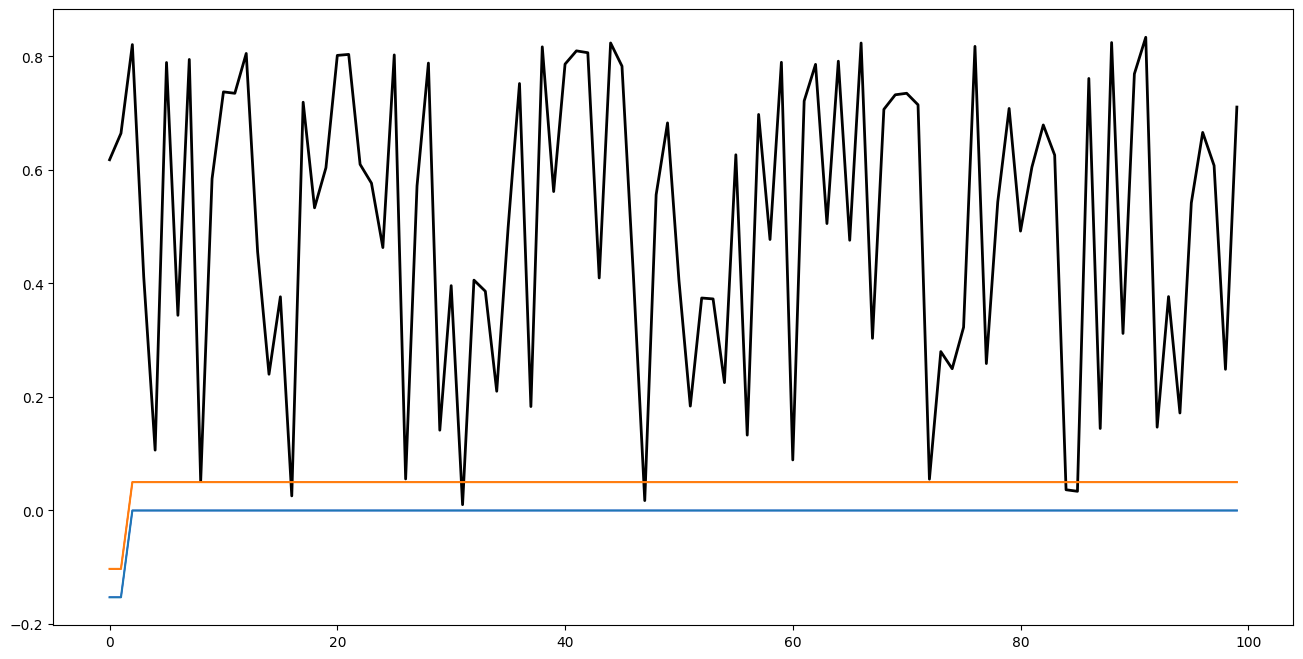

c_k[0,0,:]:
[[ 4.92201865e-01  8.87155329e-06  2.07551599e-01 -3.65154594e-02 -4.54010189e-01 -4.86935079e-02  2.90111247e-02  1.56317890e-01  2.86704570e-01
   2.78871775e-01 -1.44113556e-01  2.46113062e-01 -9.82341170e-03  3.88468392e-02  1.50723487e-01  4.30065617e-02  1.01235621e-01  2.63142765e-01
  -1.23334303e-01  2.48279661e-01 -1.95955157e-01  7.99571499e-02 -1.32444069e-01 -3.84637006e-02 -4.29068394e-02 -6.64684772e-02  1.68044064e-02
  -4.16456163e-02  3.96939740e-02 -2.62425654e-03  3.71942818e-02  3.01451404e-02  2.21913103e-02  5.03154695e-02  3.71439452e-03  5.85996956e-02
  -1.32728955e-02  5.81161156e-02 -2.66496986e-02  5.21475002e-02 -3.59480456e-02  4.33180705e-02 -4.15214933e-02  3.34626436e-02 -4.40378673e-02
   2.37403288e-02 -4.42237072e-02  1.48098078e-02 -4.27358672e-02  6.98944647e-03]]
gu_cs[0,0,:]:
[ 0.4922016   0.          0.20755222 -0.0365148  -0.4540101  -0.04869391  0.02901169  0.15631846  0.28670356  0.2788683  -0.14411198  0.24611463
 -0.0098251   0

In [29]:
test_reconstruction(
    the_measure="fru", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=print_all
)

#### FouT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fout LTI model with 0.5 transform

Testing BRYANS HiPPO-fout model
Creating HiPPO-fout LTI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-fout
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


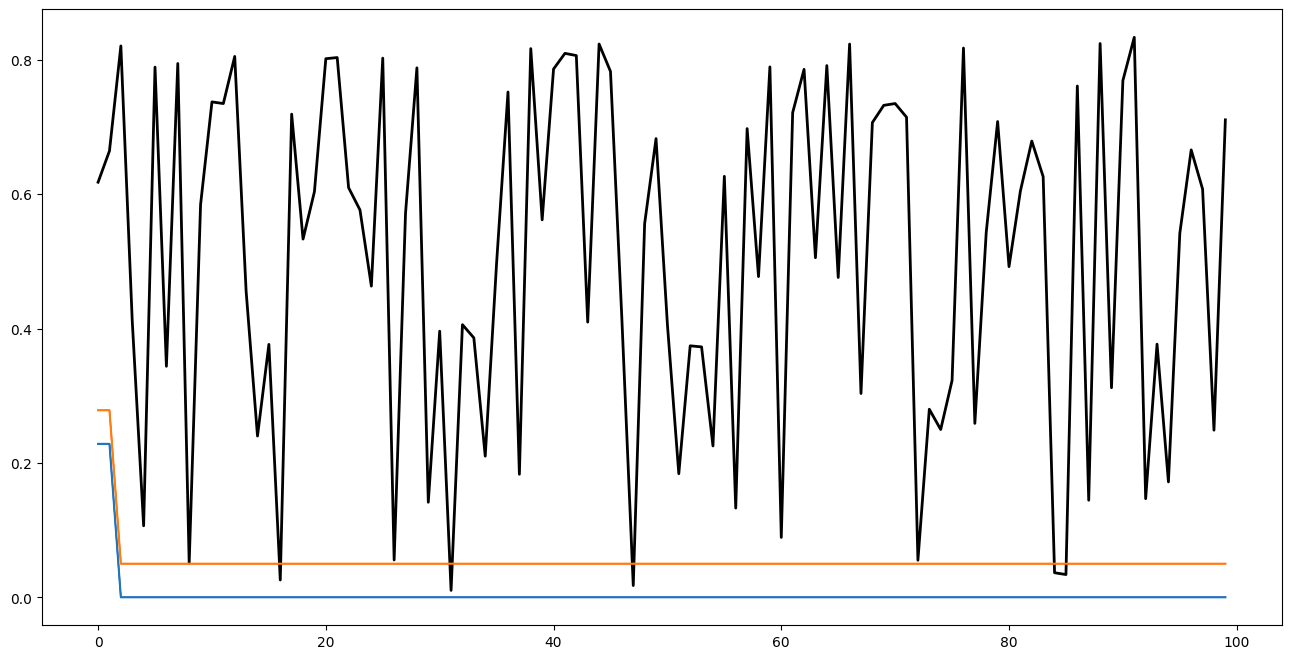

c_k[0,0,:]:
[[ 5.8393061e-01  4.4323115e-05 -1.9975391e-01  1.3573234e-01  4.6023512e-01  4.1696629e-01 -6.6826761e-02 -6.4902879e-02  2.2935320e-01
   4.5254591e-01 -3.8048384e-01  1.4679492e-01 -9.4449751e-02 -1.5864898e-01  8.5191846e-02 -4.1544620e-02  6.5937713e-02  7.1669973e-02
   1.3331011e-03  1.0059790e-01 -4.4906083e-02  8.2727805e-02 -6.5433949e-02  5.1659748e-02 -6.8154290e-02  2.2929953e-02 -6.1353751e-02
   1.2352709e-03 -5.0590806e-02 -1.3328193e-02 -3.8993768e-02 -2.2135947e-02 -2.8110590e-02 -2.6747704e-02 -1.8591516e-02 -2.8488161e-02
  -1.0596379e-02 -2.8354175e-02 -4.0609436e-03 -2.7054390e-02  1.1782508e-03 -2.5077492e-02  5.3117899e-03 -2.2755314e-02  8.5264314e-03
  -2.0296352e-02  1.0989017e-02 -1.7837137e-02  1.2842492e-02 -1.5461510e-02]]
gu_cs[0,0,:]:
[ 0.58393115  0.         -0.199753    0.13573429  0.46023458  0.41696322 -0.06682671 -0.06489959  0.22935411  0.45253938 -0.38047874  0.14679757
 -0.09444891 -0.15865074  0.08519027 -0.04154715  0.06593636  0.0

In [30]:
test_reconstruction(
    the_measure="fout", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=print_all
)

#### FouD

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-foud LTI model with 0.5 transform

Testing BRYANS HiPPO-foud model
Creating HiPPO-foud LTI model with 0.5 transform
Bryan's Coeffiecients for 0.5 LTI HiPPO-foud
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


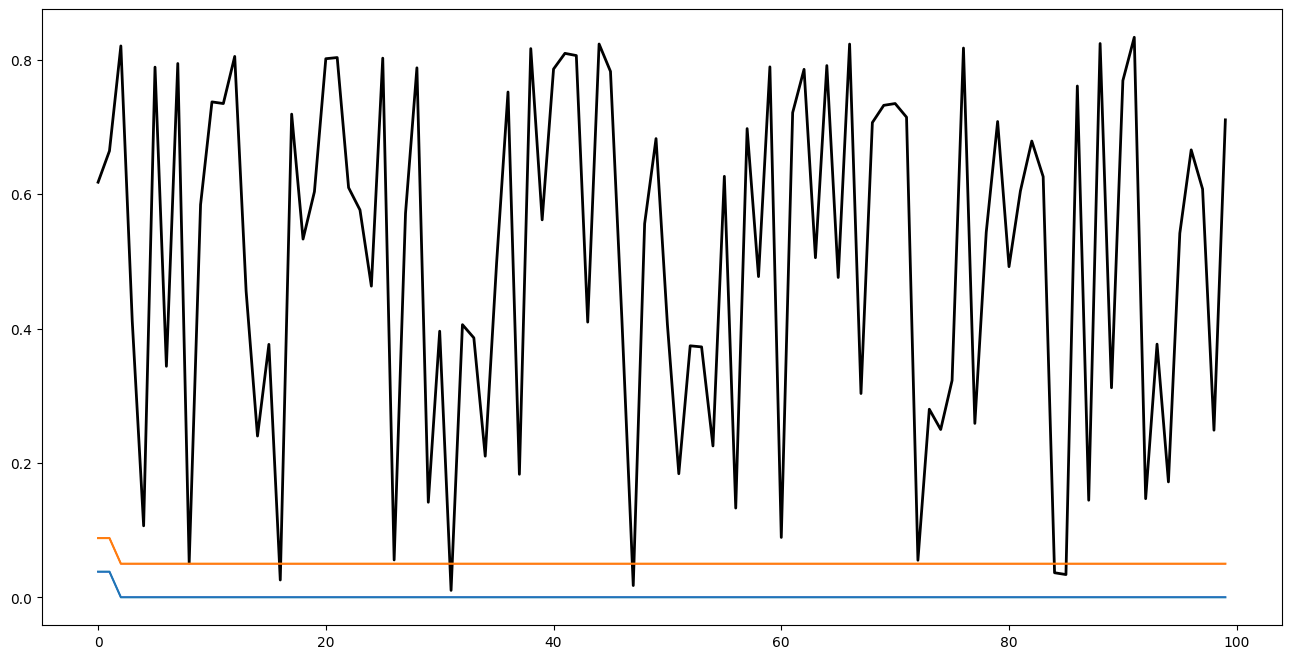

c_k[0,0,:]:
[[ 5.1101464e-01  6.9970311e-06  1.0773297e-01 -1.4861897e-02 -3.2145375e-01  1.0398872e-02  3.1577520e-02  1.0550748e-01  1.6530752e-01
   1.5249844e-01 -9.8383345e-02  1.4586912e-01 -8.2366504e-03  1.2295941e-02  1.0024923e-01  1.4980951e-02  7.3135361e-02  1.6473162e-01
  -7.6256976e-02  1.6194329e-01 -1.2902279e-01  5.2942559e-02 -9.0165772e-02 -2.7128546e-02 -3.1249810e-02 -4.8257895e-02  9.7093806e-03
  -3.3483829e-02  2.6826302e-02 -7.9905754e-03  2.6891377e-02  1.4367146e-02  1.8126387e-02  2.8945107e-02  6.4810542e-03  3.5843030e-02
  -4.6592825e-03  3.6892176e-02 -1.3759549e-02  3.4136515e-02 -2.0386642e-02  2.9265482e-02 -2.4673900e-02  2.3489978e-02 -2.6993033e-02
   1.7595228e-02 -2.7773663e-02  1.2044456e-02 -2.7419841e-02  7.0825033e-03]]
gu_cs[0,0,:]:
[ 0.5110147   0.          0.107733   -0.01486127 -0.3214547   0.01039867  0.03157864  0.10550565  0.16530685  0.15249804 -0.09838268  0.14587092
 -0.00823735  0.01229567  0.10024796  0.01498124  0.0731362   0.1

In [31]:
test_reconstruction(
    the_measure="foud", lambda_n=1.0, alpha=0.5, discretization=0.5, print_all=print_all
)

### Testing (LTI and LSI) Operators With ZOH Transform

#### LegS

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legs LTI model with 2.0 transform
Creating Gu's HiPPO-legs LSI model with 2.0 transform

Testing BRYANS HiPPO-legs model
Creating HiPPO-legs LTI model with 2.0 transform
Creating HiPPO-legs LSI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-legs
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


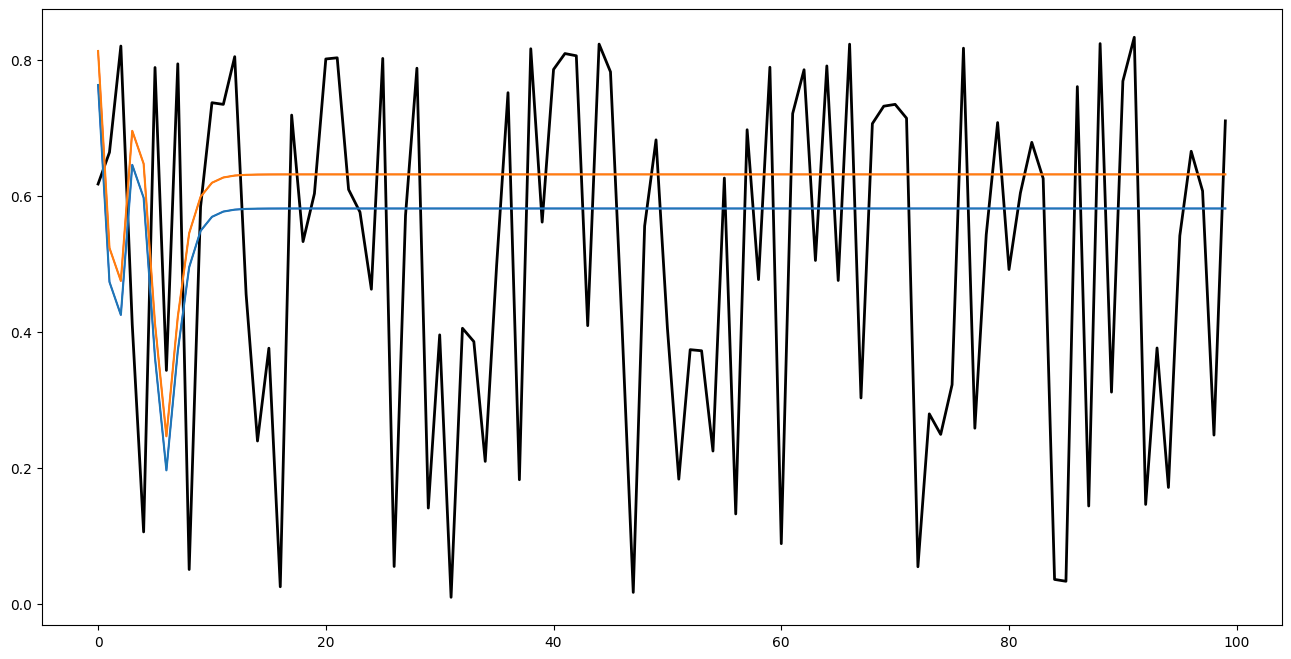

c_k[0,0,:]:
[[ 5.8803821e-01  1.1584316e-01  1.4251992e-03 -8.7546512e-02  6.3932896e-02  2.1888260e-02 -7.0402481e-02  4.5903906e-02  1.4174171e-03
  -1.3917275e-02 -5.9925844e-03  1.6832344e-02 -2.4643999e-03 -1.1032557e-02 -2.8615072e-04  2.2160791e-02 -2.3441961e-02  9.3562121e-05
   2.0437678e-02 -1.7113024e-02  7.4388646e-04  5.3101089e-03  2.2749410e-03 -6.5979604e-03 -1.3355217e-03  9.1871005e-03 -2.7312543e-03
  -1.2082011e-02  1.6746495e-02 -5.7919580e-03 -6.3369861e-03  5.6895399e-03  3.3491263e-03 -6.8472000e-03  1.9018368e-03  9.6850842e-04
   4.6906509e-03 -1.0878737e-02  6.9930055e-03  4.0393369e-03 -9.0995021e-03  2.7535236e-03  5.8977790e-03 -6.4104395e-03  7.1418798e-04
   1.6103731e-03  1.8399877e-03 -3.4359088e-03 -1.9826514e-03  8.4777493e-03]]
gu_cs[0,0,:]:
[ 5.8804429e-01  1.1583835e-01  1.4275610e-03 -8.7548852e-02  6.3934453e-02  2.1887481e-02 -7.0401937e-02  4.5903590e-02  1.4176928e-03
 -1.3917560e-02 -5.9923693e-03  1.6832097e-02 -2.4639829e-03 -1.1033060e-0

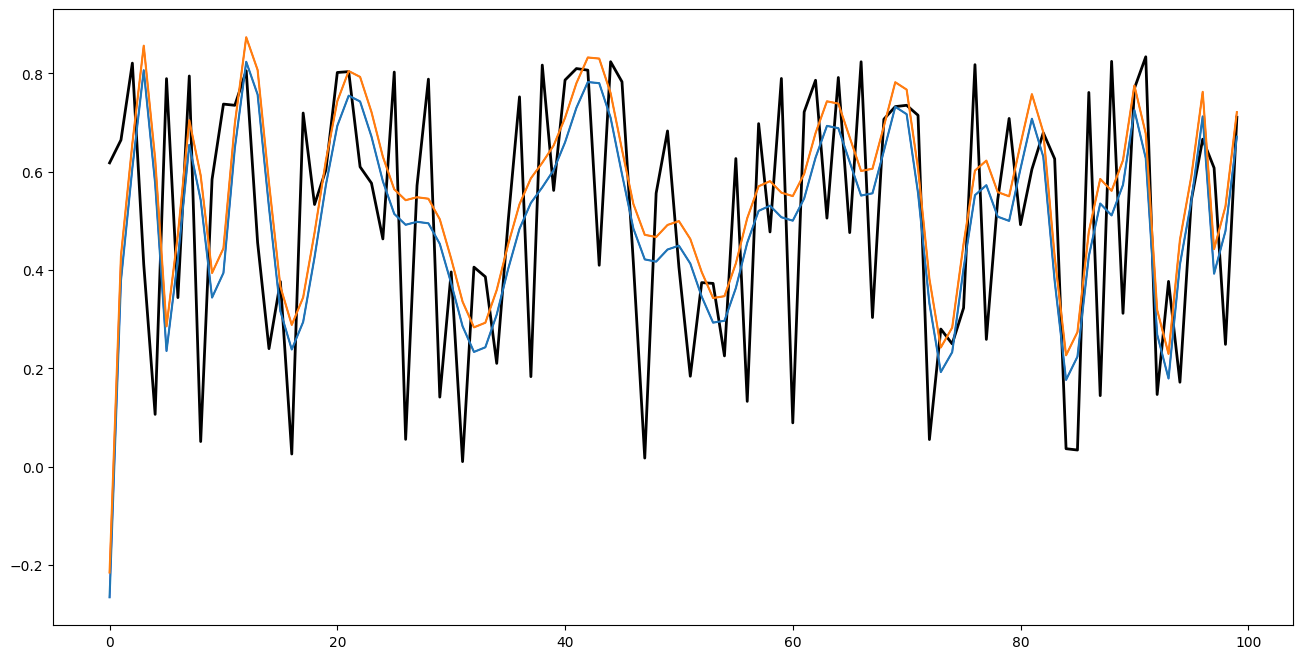

c_k[0,0,:,:]:
[[ 3.0897608e-01  2.6758516e-01 -3.7753961e-07 -1.0218533e-01 -8.2874550e-08  6.4048648e-02 -3.0157128e-07 -4.6745025e-02  1.7150427e-07
   3.6826652e-02 -7.3666264e-08 -3.0388560e-02 -1.5884288e-07  2.5870088e-02 -1.2028320e-07 -2.2522401e-02 -2.1639465e-07  1.9943101e-02
  -3.4531062e-09 -1.7894078e-02  7.2515228e-08  1.6226998e-02  6.9637643e-08 -1.4844397e-02 -8.4025579e-08  1.3679104e-02 -1.9682705e-07
  -1.2683091e-02 -1.5366322e-07  1.1822820e-02  7.1939709e-08 -1.1071643e-02 -7.3666264e-08  1.0410302e-02  7.8845922e-08 -9.8236091e-03
   1.0481616e-07  9.2991991e-03  1.4042632e-07 -8.8283410e-03  5.1796594e-09  8.4026773e-03 -2.8775885e-08 -8.0161067e-03 -1.8934531e-07
   7.6639690e-03 -3.3840439e-07 -7.3406142e-03 -1.7323083e-07  7.0442697e-03]]
gu_cs[0,0,:,:]:
[[ 3.08978707e-01  2.67583400e-01  9.82216903e-08 -1.02185272e-01  2.35732045e-07  6.40475377e-02  5.47235118e-07 -4.67454493e-02  3.92886761e-07
   3.68264727e-02  2.94665057e-07 -3.03888358e-02 -3.1733162

In [32]:
test_reconstruction(
    the_measure="legs",
    lambda_n=1.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)

#### LegT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-legt LTI model with 2.0 transform

Testing BRYANS HiPPO-legt model
Creating HiPPO-legt LTI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-legt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


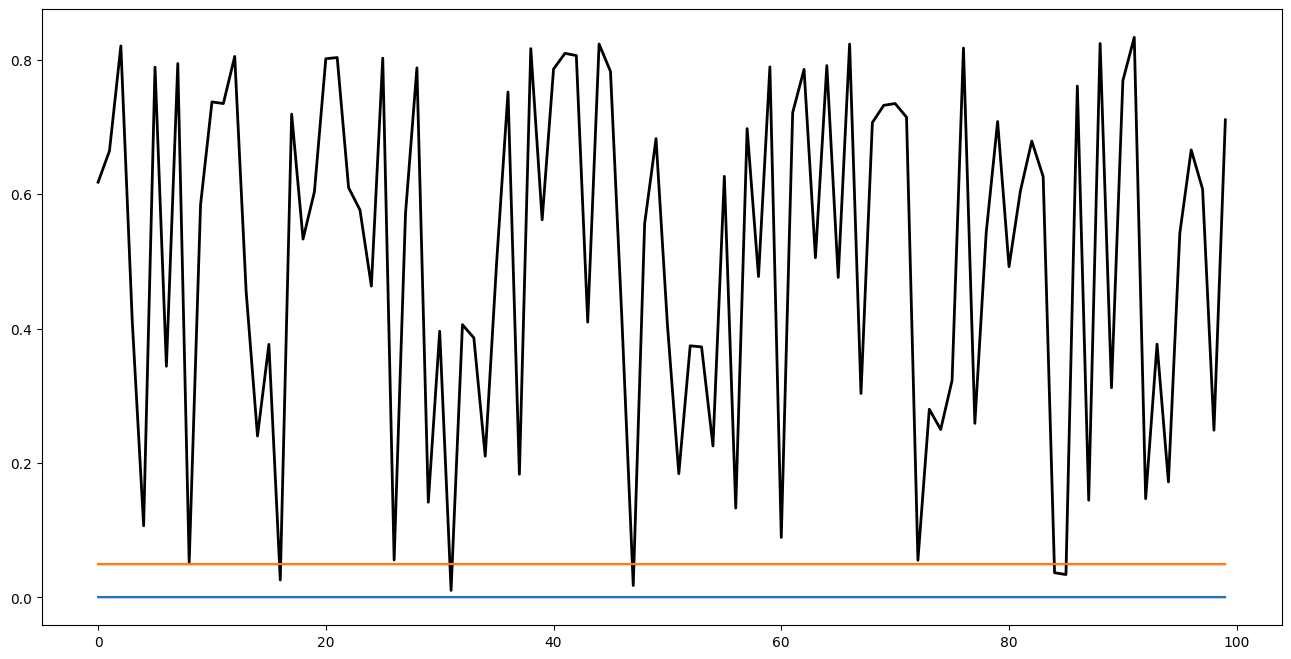

c_k[0,0,:]:
[[ 7.0930922e-01  2.6154974e-03 -3.4019072e-03  4.0009799e-03 -4.4934228e-03  4.8962962e-03 -5.2082967e-03  5.4171244e-03 -5.5044512e-03
   5.4520066e-03 -5.2430416e-03  4.8628012e-03 -4.3042554e-03  3.5768137e-03 -2.7075415e-03  1.7433781e-03 -7.5417850e-04 -1.7233138e-04
   9.4085938e-04 -1.4620511e-03  1.6711807e-03 -1.5482672e-03  1.1321165e-03 -5.2374200e-04 -1.2626470e-04  6.5062148e-04 -9.1133593e-04
   8.4660860e-04 -5.0122512e-04  2.1508138e-05  3.9338577e-04 -5.7300646e-04  4.5690368e-04 -1.3167535e-04 -2.0801317e-04  3.6720472e-04
  -2.7068704e-04  1.4857071e-05  1.9883523e-04 -2.1703342e-04  5.7518082e-05  1.1192182e-04 -1.3516026e-04  2.1185264e-05  7.8913916e-05
  -5.8164915e-05 -2.1713849e-05  3.8319813e-05  3.9807874e-06 -9.4848110e-06]]
gu_cs[0,0,:]:
[ 7.0926464e-01  2.6367290e-03 -3.3951192e-03  3.9970772e-03 -4.4929516e-03  4.8972331e-03 -5.2084872e-03  5.4161176e-03 -5.5038240e-03
  5.4525179e-03 -5.2435510e-03  4.8626312e-03 -4.3043476e-03  3.5770321e-0

In [33]:
test_reconstruction(
    the_measure="legt",
    lambda_n=1.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)

#### LMU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lmu LTI model with 2.0 transform

Testing BRYANS HiPPO-lmu model
Creating HiPPO-lmu LTI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-lmu
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


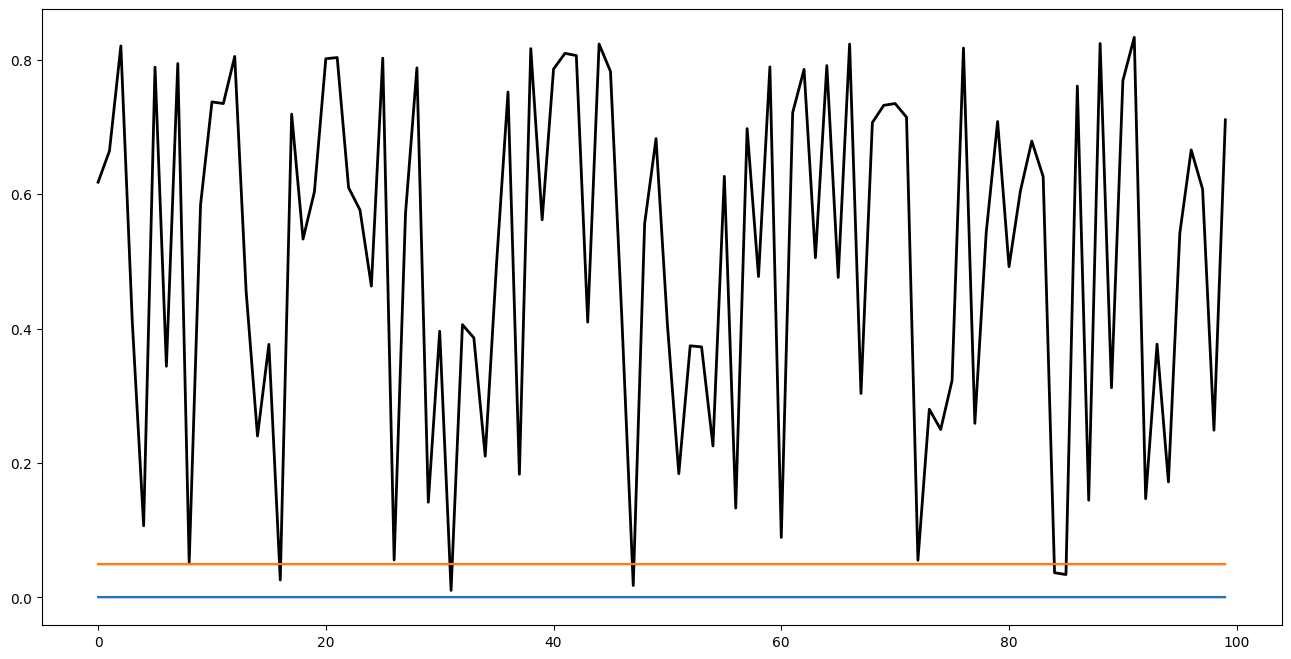

c_k[0,0,:]:
[[ 7.0930862e-01 -4.5310007e-03 -7.6066679e-03 -1.0585529e-02 -1.3480571e-02 -1.6239028e-02 -1.8778946e-02 -2.0979926e-02 -2.2694632e-02
  -2.3764256e-02 -2.4026463e-02 -2.3320731e-02 -2.1520928e-02 -1.8585976e-02 -1.4580749e-02 -9.7066928e-03 -4.3326486e-03  1.0196792e-03
   5.7227295e-03  9.1303326e-03  1.0701270e-02  1.0152901e-02  7.5944518e-03  3.5902201e-03 -8.8394625e-04 -4.6462053e-03 -6.6344636e-03
  -6.2783882e-03 -3.7844761e-03 -1.6569126e-04  3.0728434e-03  4.5484761e-03  3.6836073e-03  1.0778224e-03 -1.7279856e-03 -3.0943837e-03
  -2.3126549e-03 -1.2868317e-04  1.7447178e-03  1.9289798e-03  5.1766395e-04 -1.0189828e-03 -1.2460377e-03 -1.9852878e-04  7.4434374e-04
   5.5539579e-04 -2.0923997e-04 -3.7396656e-04  3.9161525e-05  9.4544812e-05]]
gu_cs[0,0,:]:
[ 7.09264696e-01 -4.56691720e-03 -7.59163592e-03 -1.05751827e-02 -1.34787550e-02 -1.62421204e-02 -1.87793113e-02 -2.09764261e-02 -2.26927772e-02
 -2.37669051e-02 -2.40288917e-02 -2.33202502e-02 -2.15216056e-02 

In [34]:
test_reconstruction(
    the_measure="lmu",
    lambda_n=2.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)

#### LagT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-lagt LTI model with 2.0 transform

Testing BRYANS HiPPO-lagt model
Creating HiPPO-lagt LTI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-lagt
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


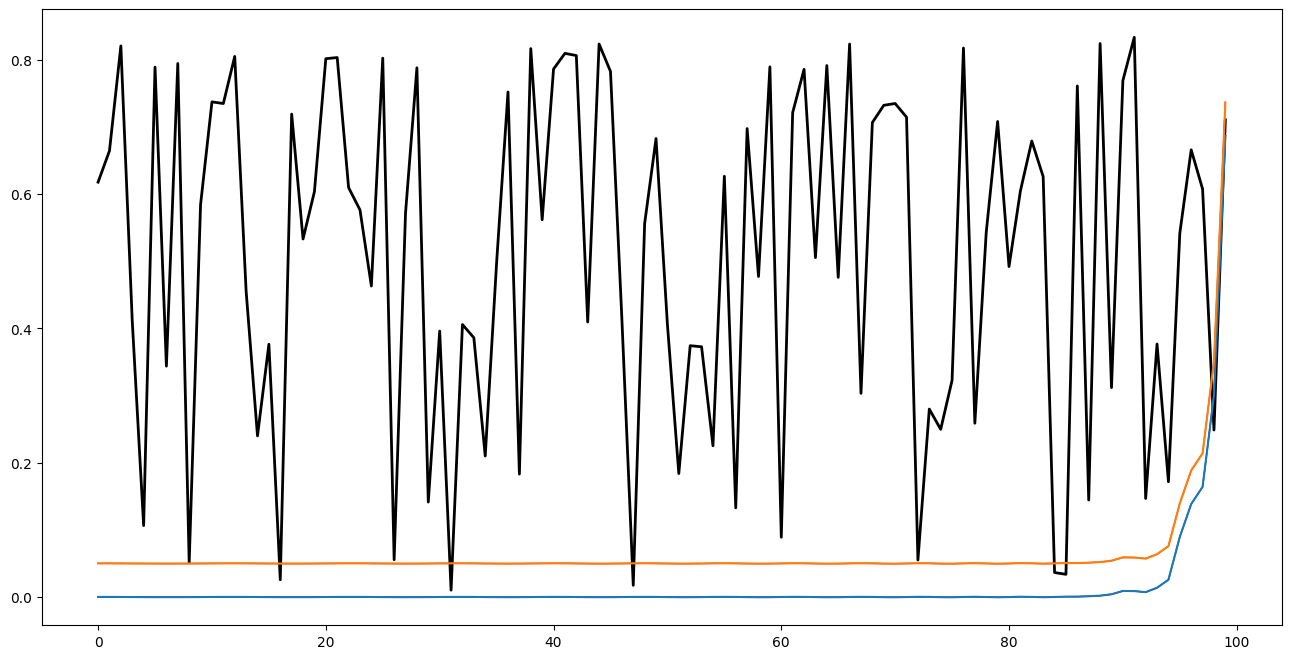

c_k[0,0,:]:
[[ 5.8804393e-01  8.2458943e-02  6.8646856e-02  5.9013162e-02  3.6913875e-02  2.3570135e-03 -3.1868245e-02 -5.3210378e-02 -5.7459921e-02
  -4.8296615e-02 -3.2543082e-02 -1.6043734e-02 -2.0473124e-03  8.4742550e-03  1.5814409e-02  2.0650467e-02  2.3557056e-02  2.4866506e-02
   2.4725474e-02  2.3222456e-02  2.0496484e-02  1.6790949e-02  1.2440169e-02  7.8145955e-03  3.2520741e-03 -9.9250488e-04 -4.7646165e-03
  -7.9931729e-03 -1.0657071e-02 -1.2744257e-02 -1.4228736e-02 -1.5067684e-02 -1.5214483e-02 -1.4646245e-02 -1.3388330e-02 -1.1527720e-02
  -9.2137400e-03 -6.6443551e-03 -4.0373970e-03 -1.6014865e-03  4.9033388e-04  2.1227282e-03  3.2482459e-03  3.8838431e-03  4.1028648e-03
   4.0175468e-03  3.7567080e-03  3.4479769e-03  3.1993962e-03  3.0867937e-03]]
gu_cs[0,0,:]:
[ 5.8804429e-01  8.2458675e-02  6.8646930e-02  5.9013203e-02  3.6913797e-02  2.3570322e-03 -3.1868279e-02 -5.3210396e-02 -5.7460029e-02
 -4.8296634e-02 -3.2543261e-02 -1.6043648e-02 -2.0472468e-03  8.4742308e-0

In [35]:
test_reconstruction(
    the_measure="lagt",
    lambda_n=1.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)

#### FRU

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fru LTI model with 2.0 transform

Testing BRYANS HiPPO-fru model
Creating HiPPO-fru LTI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-fru
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


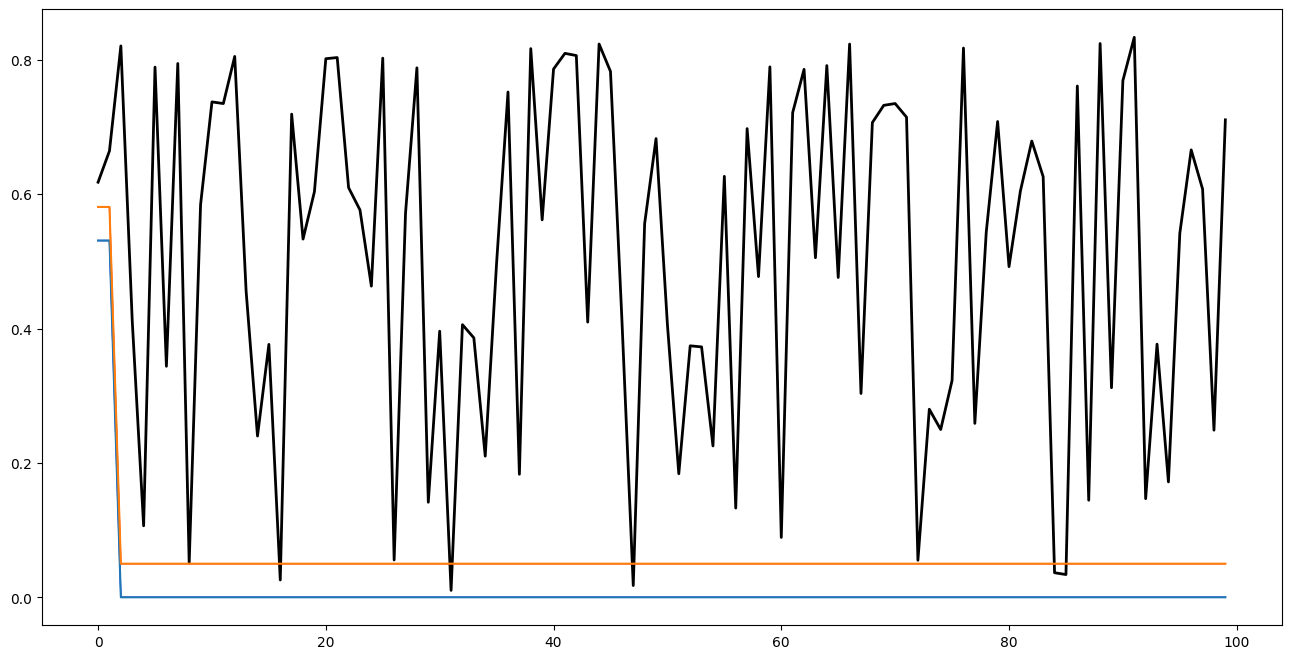

c_k[0,0,:]:
[[ 4.8191395e-01  0.0000000e+00 -2.9985094e-05  2.0797843e-01  3.0136155e-03  1.4368117e-04 -3.0600931e-05  6.9325253e-02  3.0146558e-03
   2.9031985e-04 -3.2229349e-05  4.1593976e-02  3.0160574e-03  4.4200983e-04 -3.5026344e-05  2.9708205e-02  3.0169399e-03  6.0205208e-04
  -3.9146282e-05  2.3103800e-02  3.0162912e-03  7.7400805e-04 -4.5357505e-05  1.8898578e-02  3.0118462e-03  9.6252665e-04 -5.4158038e-05
   1.5982989e-02  3.0001574e-03  1.1735946e-03 -6.6229608e-05  1.3836686e-02  2.9750024e-03  1.4155916e-03 -8.1136124e-05  1.2178791e-02
   2.9244581e-03  1.6999580e-03 -9.2687551e-05  1.0834550e-02  2.8248047e-03  2.0420207e-03 -6.3324347e-05  9.6646016e-03  2.6304682e-03
   2.4522915e-03  3.0679419e-04  8.5240118e-03  2.6010226e-03  2.9295913e-03]]
gu_cs[0,0,:]:
[ 4.8191231e-01  0.0000000e+00 -2.9978808e-05  2.0797910e-01  3.0136185e-03  1.4396168e-04 -3.0711992e-05  6.9325492e-02  3.0146828e-03
  2.9044269e-04 -3.2332959e-05  4.1594058e-02  3.0160423e-03  4.4216245e-0

In [36]:
test_reconstruction(
    the_measure="fru",
    lambda_n=1.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)

#### FouT

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-fout LTI model with 2.0 transform

Testing BRYANS HiPPO-fout model
Creating HiPPO-fout LTI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-fout
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


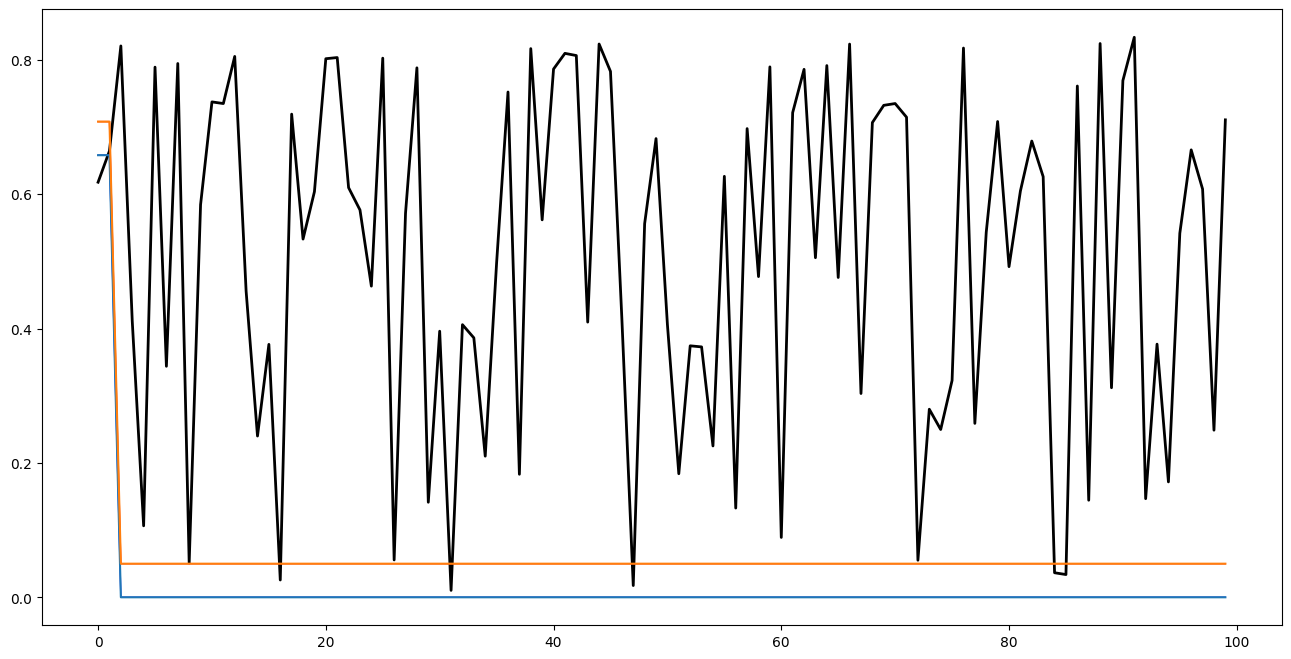

c_k[0,0,:]:
[[ 7.0956457e-01  0.0000000e+00 -1.7340579e-03 -5.3404765e-05 -1.7331241e-03 -1.0557037e-04 -1.7317852e-03 -1.5860659e-04 -1.7297524e-03
  -2.1229380e-04 -1.7272248e-03 -2.6695020e-04 -1.7238207e-03 -3.2268791e-04 -1.7195729e-03 -3.7980941e-04 -1.7143945e-03 -4.3862089e-04
  -1.7079698e-03 -4.9950241e-04 -1.7001806e-03 -5.6270190e-04 -1.6905911e-03 -6.2868098e-04 -1.6789093e-03 -6.9798622e-04 -1.6645070e-03
  -7.7115820e-04 -1.6466923e-03 -8.4893318e-04 -1.6245492e-03 -9.3201909e-04 -1.5965368e-03 -1.0214454e-03 -1.5608675e-03 -1.1184806e-03
  -1.5144954e-03 -1.2244337e-03 -1.4529574e-03 -1.3409711e-03 -1.3688449e-03 -1.4698075e-03 -1.2491711e-03 -1.6118656e-03 -1.0687846e-03
  -1.7638489e-03 -7.7211740e-04 -1.8998459e-03 -2.3856224e-04 -1.8260498e-03]]
gu_cs[0,0,:]:
[ 7.0956248e-01  0.0000000e+00 -1.7338835e-03 -5.2524883e-05 -1.7330861e-03 -1.0524916e-04 -1.7317400e-03 -1.5839069e-04 -1.7297779e-03
 -2.1217167e-04 -1.7271581e-03 -2.6682808e-04 -1.7238136e-03 -3.2259515e-0

In [37]:
test_reconstruction(
    the_measure="fout",
    lambda_n=1.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)

#### FouD

x.shape: (2, 100, 1)
x.shape: (2, 100, 1)
Creating Gu's HiPPO-foud LTI model with 2.0 transform

Testing BRYANS HiPPO-foud model
Creating HiPPO-foud LTI model with 2.0 transform
Bryan's Coeffiecients for 2.0 LTI HiPPO-foud
------------------------------------------------------------------------------------------
----------------------------My lti Implementation Outputs----------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
---------------------------Gu's lti Implementation Outputs---------------------------
------------------------------------------------------------------------------------------
spec_x.shape: (100,)
spec_gu_y.shape: torch.Size([100])
spec_y.shape: (100,)


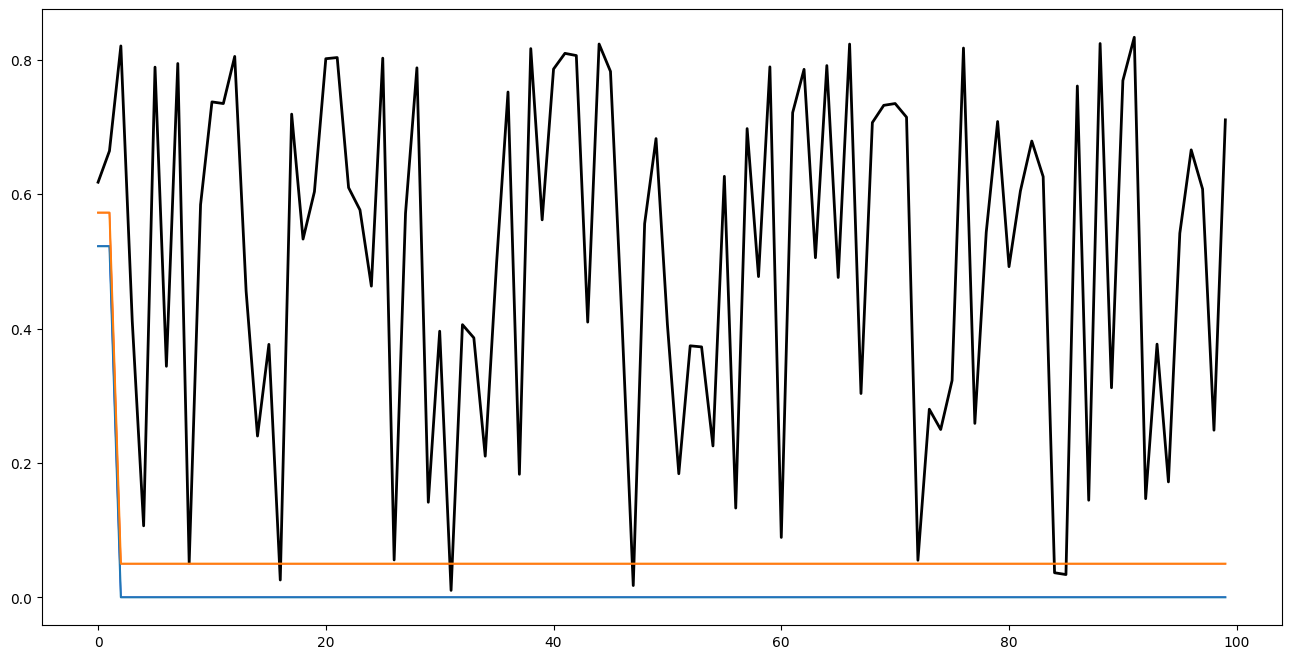

c_k[0,0,:]:
[[5.0359815e-01 0.0000000e+00 2.2505992e-05 1.4706579e-01 9.0314646e-04 1.9063613e-05 2.2896216e-05 4.9027011e-02 9.0802944e-04 3.8609931e-05
  2.3522181e-05 2.9422577e-02 9.1633835e-04 5.9070149e-05 2.4819456e-05 2.1023601e-02 9.2857186e-04 8.1040729e-05 2.6639784e-05 1.6360050e-02
  9.4533700e-04 1.0540725e-04 2.9171410e-05 1.3395224e-02 9.6765312e-04 1.3315612e-04 3.2786047e-05 1.1346173e-02 9.9719851e-04 1.6601128e-04
  3.7999591e-05 9.8481718e-03 1.0367722e-03 2.0679570e-04 4.5844470e-05 8.7096561e-03 1.0915096e-03 2.6072667e-04 5.8681006e-05 7.8231636e-03
  1.1727815e-03 3.3986711e-04 8.2984916e-05 7.1334280e-03 1.3140655e-03 4.8135367e-04 1.4744641e-04 6.6680210e-03 1.7454835e-03 9.6951285e-04]]
gu_cs[0,0,:]:
[5.0359851e-01 0.0000000e+00 2.2442604e-05 1.4706543e-01 9.0313761e-04 1.9069113e-05 2.2829103e-05 4.9026988e-02 9.0799853e-04 3.8583254e-05
 2.3581495e-05 2.9422637e-02 9.1633783e-04 5.9051978e-05 2.4807989e-05 2.1023545e-02 9.2856673e-04 8.1067432e-05 2.664444

In [38]:
test_reconstruction(
    the_measure="foud",
    lambda_n=1.0,
    alpha=2.0,
    discretization="zoh",
    print_all=print_all,
)